In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import sys
import dask as dd
from dask import dataframe
sys.path.insert(0, "C:/workspace/data-science//libs")

from monte_carlo import CauchyGenerator, PoissonGenerator, NormalGenerator, ParetoGenerator, LognormalGenerator, Transaction, MonteCarloTransactionSimulator, CauchyParameterSearcher, LognormalParameterSearcher
from uniswap_v2_plots import show_swaps_count_moving_averages, show_swaps_reserves_evolution_through_time, show_pool_price_evolution_from_reserves, show_swaps_amount_in_moving_averages

In [2]:
def calc_price_and_increase_rates(df: pd.DataFrame):
    """Append prices conform reserves changes and find price increase rates

    Args:
        df (pd.DataFrame): reserves dataframe
    """
    #   setting current price for each reserves update
    first_price_sequence = df.reserve0 / df.reserve1
    second_price_sequence = df.reserve1 / df.reserve0
    df['first_price'] = first_price_sequence
    df['second_price'] = second_price_sequence

    first_price_sequence = first_price_sequence.shift(periods=-1)
    second_price_sequence = second_price_sequence.shift(periods=-1)

    df['first_price_increase_rate'] = ((df.first_price - first_price_sequence) / first_price_sequence) * 100
    df['second_price_increase_rate'] = ((df.second_price - second_price_sequence) / second_price_sequence) * 100

In [3]:
def increase_rate_moving_averages(df: pd.DataFrame, first_plot_name: str, second_plot_name: str, x_size: int=10, y_size: int=5, wspace: int=0.1, hspace: int=0.1):
    """plot information about increasing rates

    Args:
        df (pd.DataFrame): reserves dataframe
        first_plot_name (str): name of first plot
        second_plot_name (str): name of second plot
        x_size (int, optional): x-size of window. Defaults to 10.
        y_size (int, optional): y-size of window. Defaults to 5.
        wspace (int, optional): space between plots. Defaults to 0.1.
        hspace (int, optional): height space between plots. Defaults to 0.1.
    """
    # copy dataframe and get date as index
    transactions_time = df.copy()
    transactions_time.index = transactions_time.date
    
    # resample data and find rolling average per week
    transactions_time = transactions_time.resample('7D').mean()
    transactions_avg_time = transactions_time.rolling('14D').mean()
    
    fig = plt.subplots(figsize=(x_size, y_size))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=transactions_time, x='date', y='first_price_increase_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 1)
    sns.lineplot(data=transactions_avg_time, x='date', y='first_price_increase_rate', color='red', label='14 days rolling mean').set_title(first_plot_name)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=transactions_time, x='date', y='second_price_increase_rate', color='green', label='7 days mean')
    plt.subplot(1, 2, 2)
    sns.lineplot(data=transactions_avg_time, x='date', y='second_price_increase_rate', color='red', label='14 days rolling mean').set_title(second_plot_name)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

In [4]:
def swaps_price_increase_rates_moving_averages(df: pd.DataFrame, first_token: str, second_token: str, first_plot_name: str, second_plot_name: str, 
                                               x_size: int=10, y_size: int=5, wspace: int=0.1, hspace: int=0.1):
    """swaps price inrease rates moving averages plot using seaborn

    Args:
        df (pd.DataFrame): swaps dataframe with swaps prices and swaps prices increase rates
        first_token (str): name of the first token
        second_token (str): name of the second token
        first_plot_name (str): name of the first subplot
        second_plot_name (str): name of the second subplot
        x_size (int, optional): plot width. Defaults to 10.
        y_size (int, optional): plot height. Defaults to 5.
        wspace (int, optional): width space between subplots. Defaults to 0.1.
        hspace (int, optional): height space between subplots. Defaults to 0.1.
    """
    first_transactions_time = df[df.token_in == first_token]
    second_transactions_time = df[df.token_in == second_token]
    first_transactions_time.index = first_transactions_time.timestamp
    second_transactions_time.index = second_transactions_time.timestamp
    
    first_transactions_time = first_transactions_time.resample('1D').mean()
    first_transactions_avg_time = first_transactions_time.rolling('7D').mean()
    second_transactions_time = second_transactions_time.resample('1D').mean()
    second_transactions_avg_time = second_transactions_time.rolling('7D').mean()
    
    fig = plt.subplots(figsize=(x_size, y_size))
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=first_transactions_time, x='timestamp', y='price_change_rate', color='green', 
                 label='1 day mean')
    plt.subplot(1, 2, 1)
    sns.lineplot(data=first_transactions_avg_time, x='timestamp', y='price_change_rate', 
                 color='red', label='7 days rolling mean').set_title(first_plot_name)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=second_transactions_time, x='timestamp', y='price_change_rate', color='green', 
                 label='1 day mean')
    plt.subplot(1, 2, 2)
    sns.lineplot(data=second_transactions_avg_time, x='timestamp', y='price_change_rate', 
                 color='red', label='7 days rolling mean').set_title(second_plot_name)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()

In [5]:
def pyplot_line_swap_change_rate(df: pd.DataFrame, first_token: str, second_token: str, xsize: int=20, ysize=10, wspace: float=0.1, hspace: float=0.1):
    """plot using pyplot distribution of swap prices change rates

    Args:
        df (pd.DataFrame): swaps dataframe with found swaps prices and swaps prices change rates
        first_token (str): name of the first token
        second_token (str): name of the second token
        xsize (int, optional): width of plot. Defaults to 20.
        ysize (int, optional): height of plot. Defaults to 10.
        wspace (float, optional): width space between subplots. Defaults to 0.1.
        hspace (float, optional): height space between subplots. Defaults to 0.1.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot_date(df[(df.token_in == first_token)].timestamp, 
                df[(df.token_in == first_token)].price_change_rate, 
                linestyle='solid', marker=None, label='Ethereum price change rates')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Change rate in percents")
    ax1.set_title("Change rate for " + first_token + " price")

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot_date(df[(df.token_in == second_token)].timestamp, 
                df[(df.token_in == second_token)].price_change_rate, 
                linestyle='solid', marker=None, color='red', label='USDC price change rates')
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Change rate in percents")
    ax2.set_title("Change rate for " + second_token + " price")

    fig.autofmt_xdate()
    fig.subplots_adjust(wspace=wspace, hspace=hspace) 

    plt.show()

In [6]:
def pyplot_line_swap_prices(df: pd.DataFrame, first_token: str, second_token: str, xsize: int=20, ysize=10, wspace: float=0.1, hspace: float=0.1):
    """plot using pyplot distribution of swap prices change rates

    Args:
        df (pd.DataFrame): swaps dataframe with found swaps prices and swaps prices change rates
        first_token (str): name of the first token
        second_token (str): name of the second token
        xsize (int, optional): width of plot. Defaults to 20.
        ysize (int, optional): height of plot. Defaults to 10.
        wspace (float, optional): width space between subplots. Defaults to 0.1.
        hspace (float, optional): height space between subplots. Defaults to 0.1.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot_date(df[(df.token_in == first_token)].timestamp, 
                df[(df.token_in == first_token)].first_to_second_price, 
                linestyle='solid', marker=None, label='Ethereum price change rates')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Token price")
    ax1.set_title("Price of the " + first_token)

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot_date(df[(df.token_in == second_token)].timestamp, 
                df[(df.token_in == second_token)].first_to_second_price, 
                linestyle='solid', marker=None, color='red', label='USDC price change rates')
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Token price")
    ax2.set_title("Price of the " + second_token)

    fig.autofmt_xdate()
    fig.subplots_adjust(wspace=wspace, hspace=hspace) 

    plt.show()

In [7]:
def get_df_with_swap_prices_and_change_rates(df: pd.DataFrame, first_token: str, second_token:str) -> pd.DataFrame:
    """form swaps price and form swaps price change rate for each token independently

    Args:
        df (pd.DataFrame): swaps dataframe
        first_token (str): name of the first token
        second_token (str): name of the second token

    Returns:
        pd.DataFrame: dataframe with formed swaps price and swaps price changes
    """
    df['first_to_second_price'] = df.amount_out / df.amount_in
    df['price_change_rate'] = np.ones(len(df))

    first_token_price_story = df[df.token_in == first_token].first_to_second_price
    second_token_price_story = df[df.token_in == second_token].first_to_second_price
    first_token_price_story = first_token_price_story.shift(periods=1)
    second_token_price_story = second_token_price_story.shift(periods=1)

    first_token_df = df[df.token_in == first_token]
    second_token_df = df[df.token_in == second_token]

    first_token_df.price_change_rate = ((first_token_df.first_to_second_price - first_token_price_story) / 
                                        first_token_price_story) * 100
    second_token_df.price_change_rate = ((second_token_df.first_to_second_price - second_token_price_story) / 
                                        second_token_price_story) * 100

    df = pd.concat([first_token_df, second_token_df])
    df.sort_index(inplace=True)
    
    return df

In [8]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# DOG/WETH

In [9]:
dog_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\dog_weth_swaps.pkl')
dog_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_mints.pkl")
dog_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_burns.pkl")
dog_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\dog_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


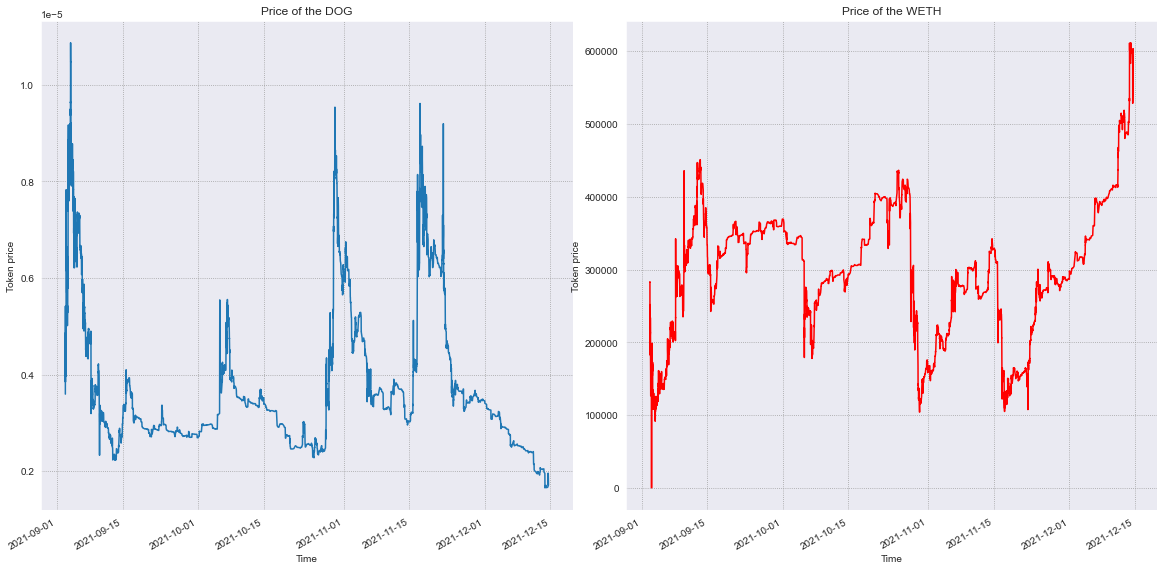

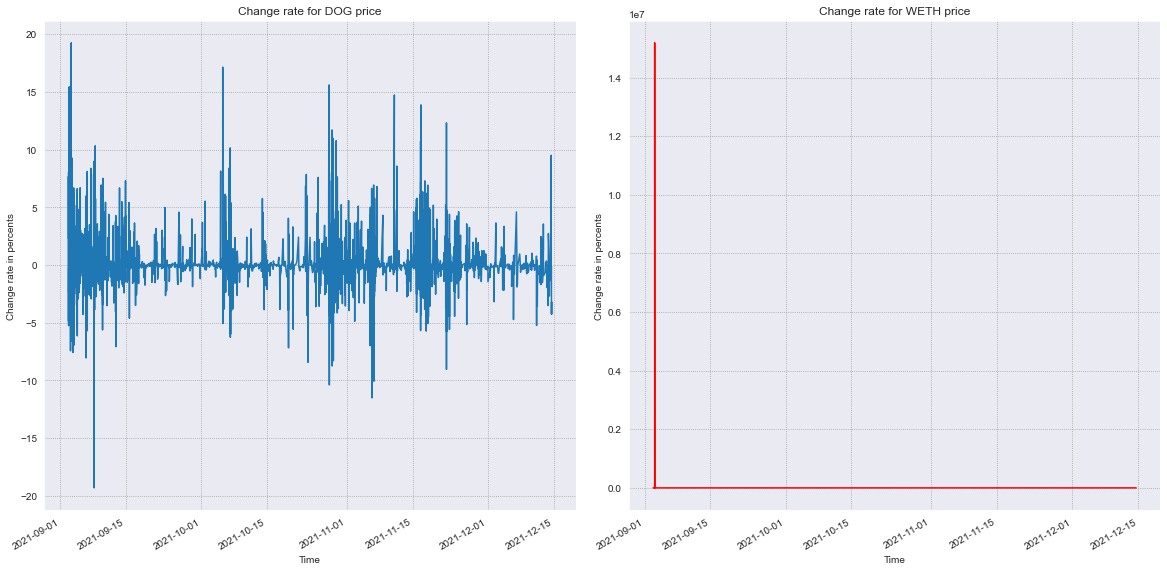

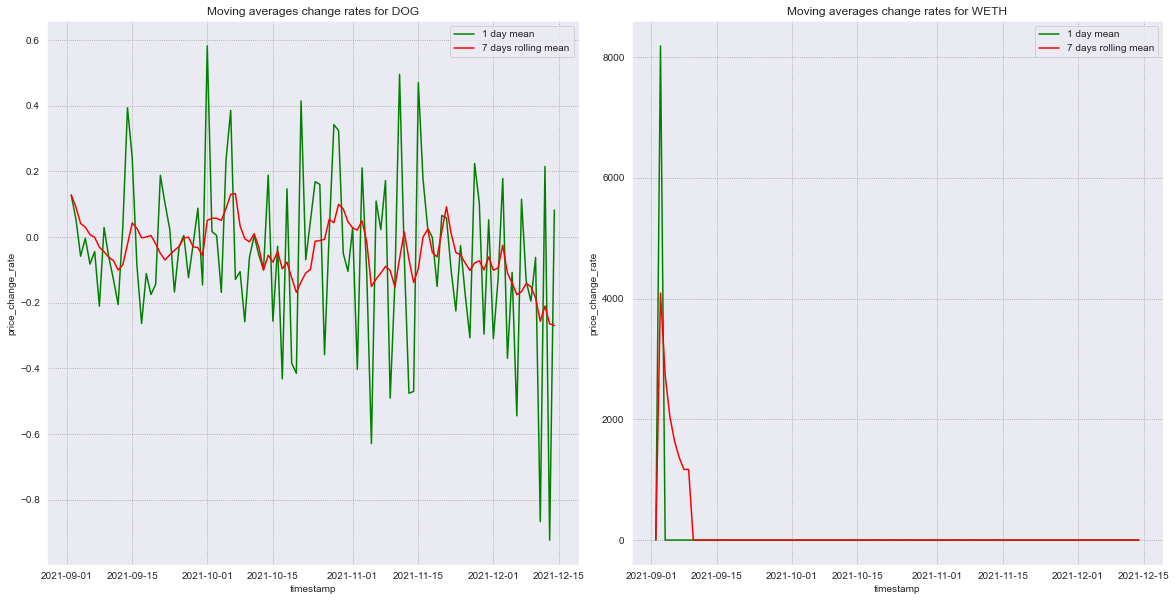

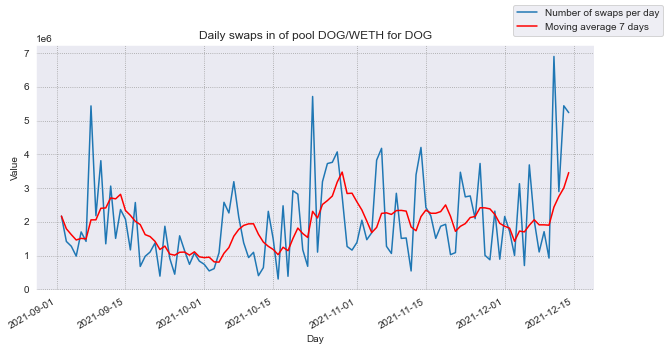

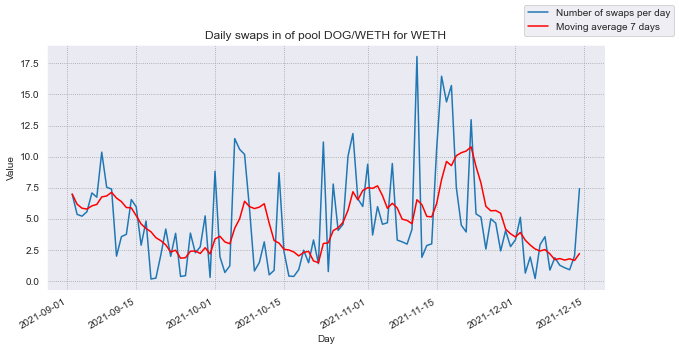

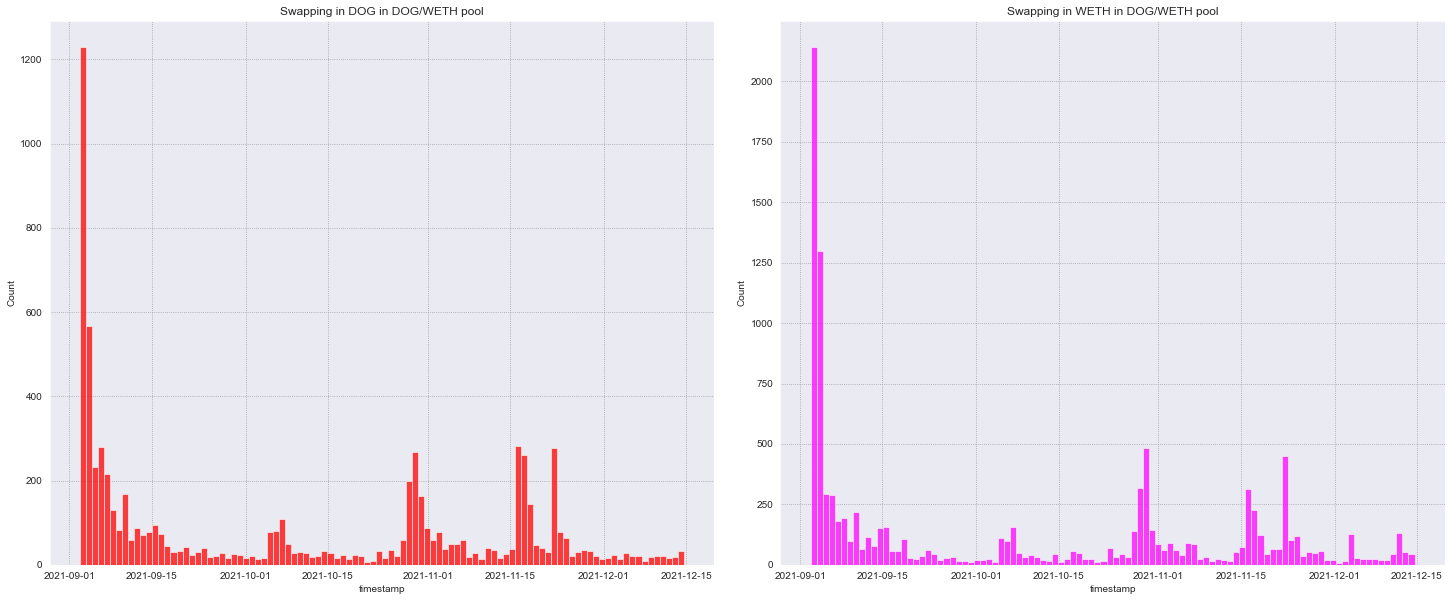

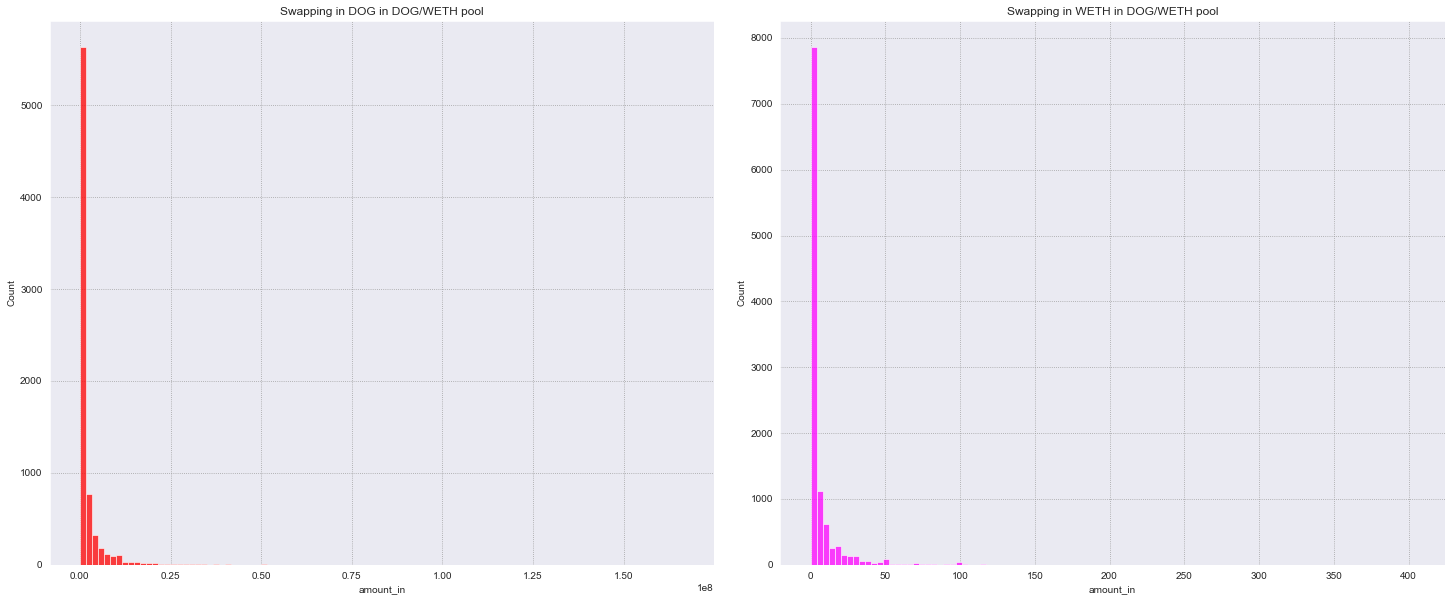

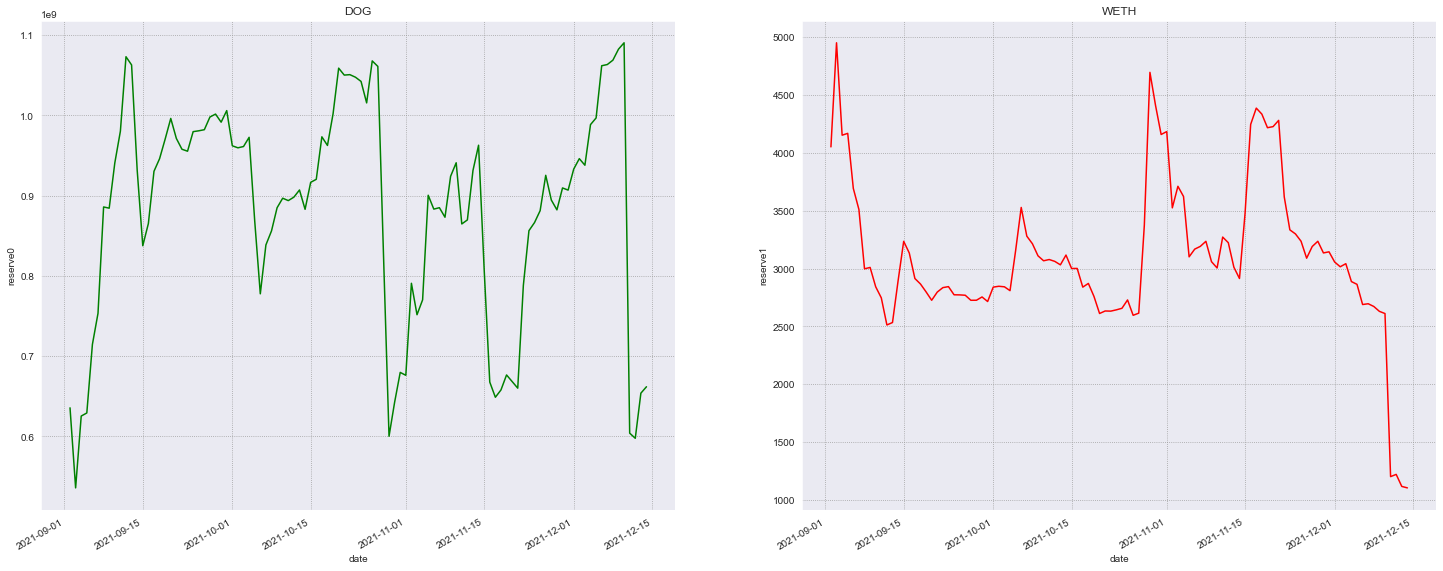

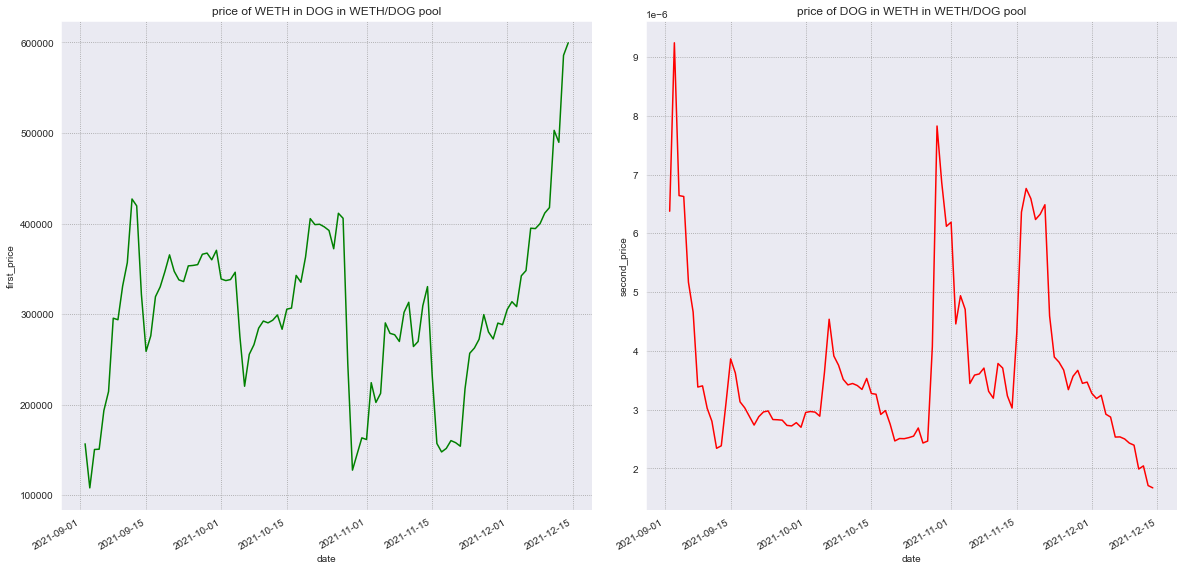

In [10]:
dog_weth_df = get_df_with_swap_prices_and_change_rates(dog_weth_df, 'DOG', 'WETH')

pyplot_line_swap_prices(dog_weth_df, 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(dog_weth_df, 'DOG', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(dog_weth_df, 'DOG', 'WETH', 'Moving averages change rates for DOG',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=dog_weth_df[(dog_weth_df.token_in == 'DOG')], 
                                     pool_name="DOG/WETH for DOG")
show_swaps_amount_in_moving_averages(swaps_df=dog_weth_df[(dog_weth_df.token_in == 'WETH')], 
                                     pool_name="DOG/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'DOG'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in DOG in DOG/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in DOG/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'DOG'], x='amount_in', bins=100, color='red').set_title("Swapping in DOG in DOG/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=dog_weth_df[dog_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in DOG/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(dog_weth_reserves_df,
                                           first_token_reserve_name="DOG", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(dog_weth_reserves_df, 
                                        first_token_price_name="price of WETH in DOG in WETH/DOG pool", 
                                        second_token_price_name="price of DOG in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

# NFD/WETH

In [11]:
nfd_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\nfd_weth_swaps.pkl')
nfd_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_mints.pkl")
nfd_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_burns.pkl")
nfd_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\nfd_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


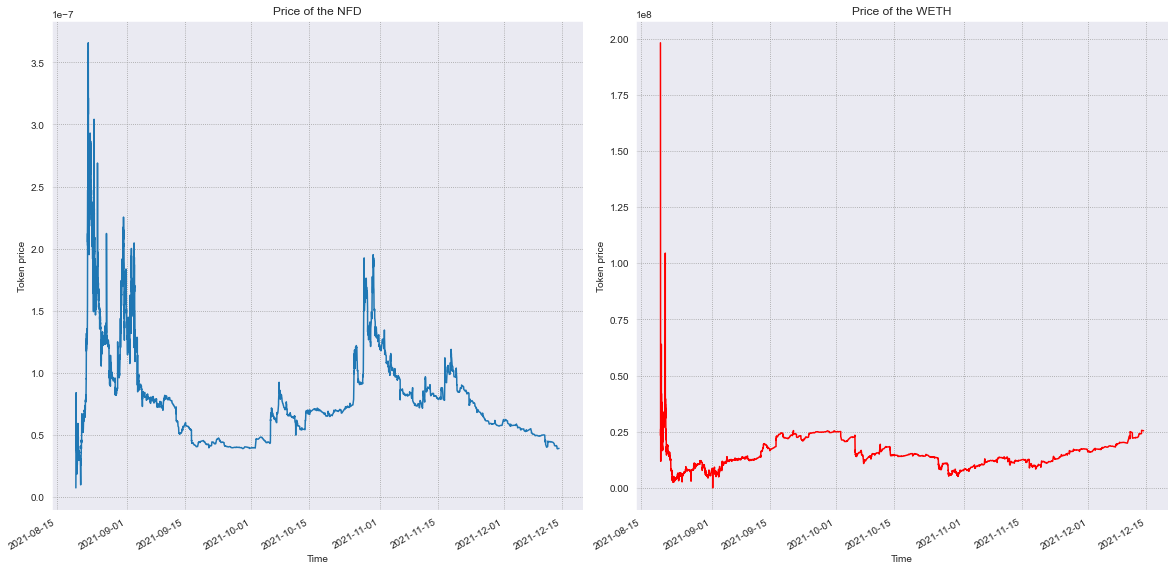

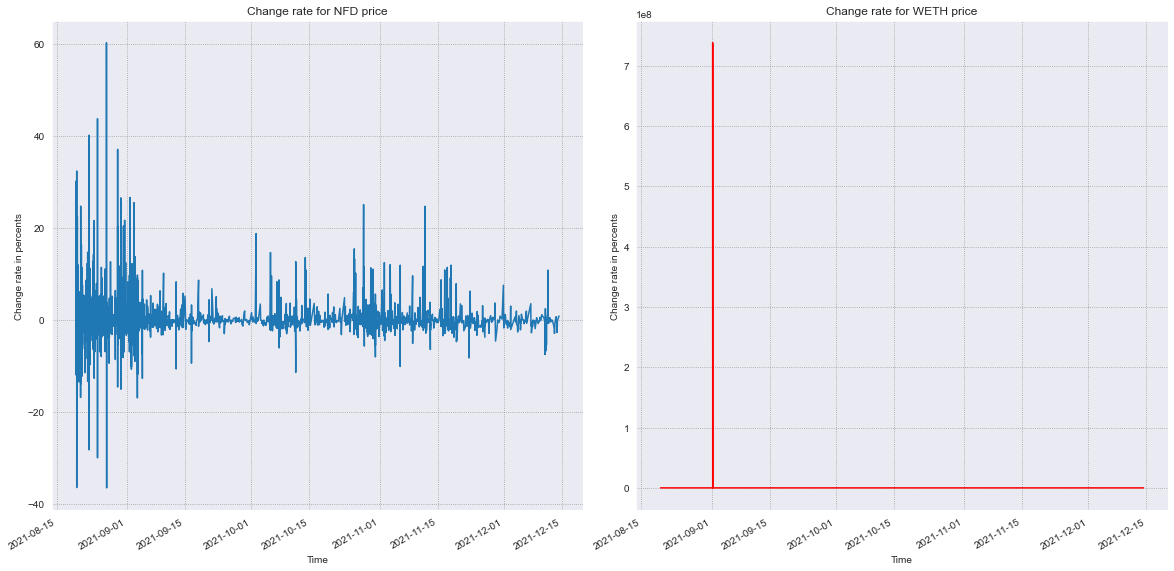

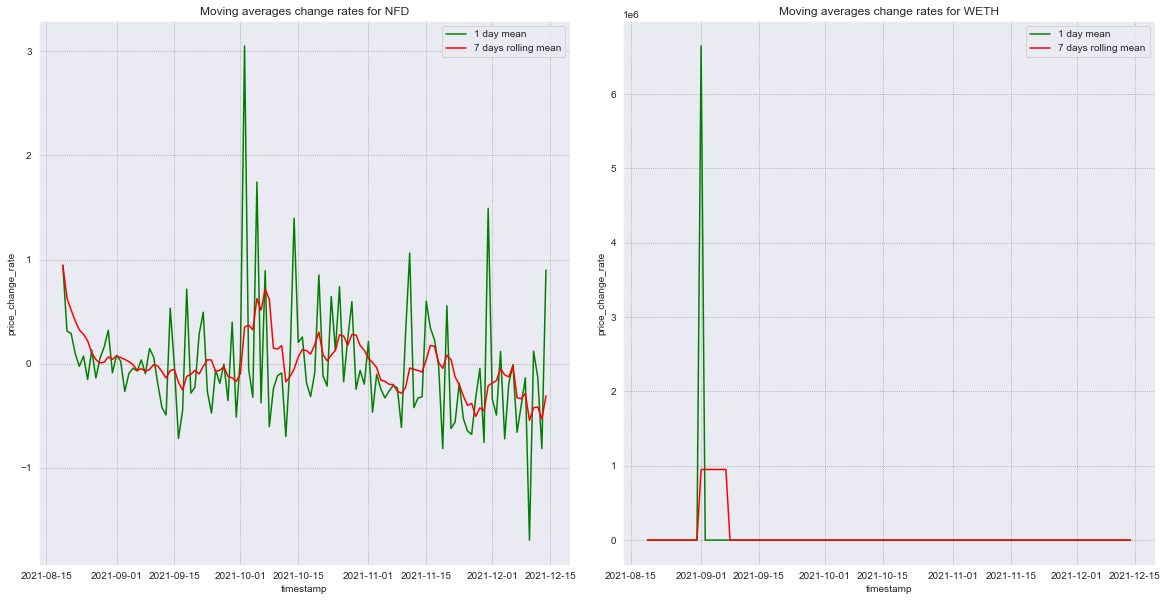

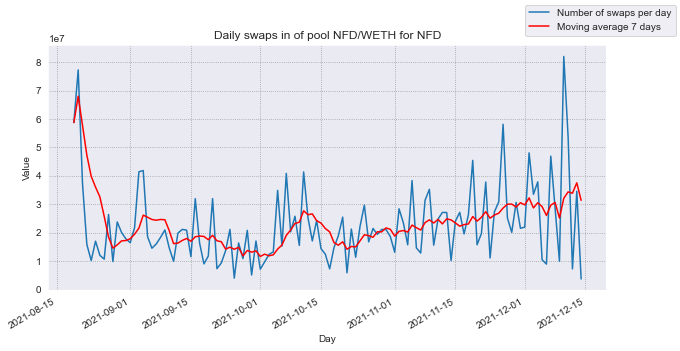

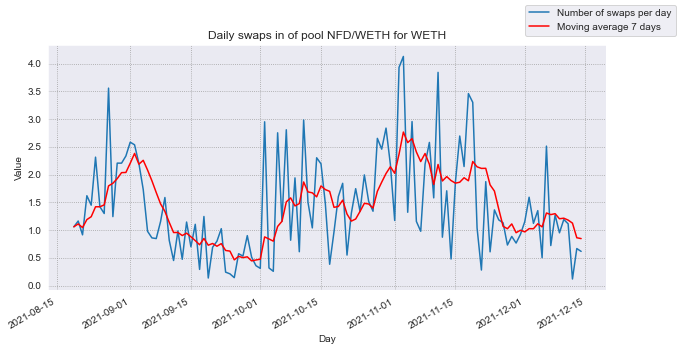

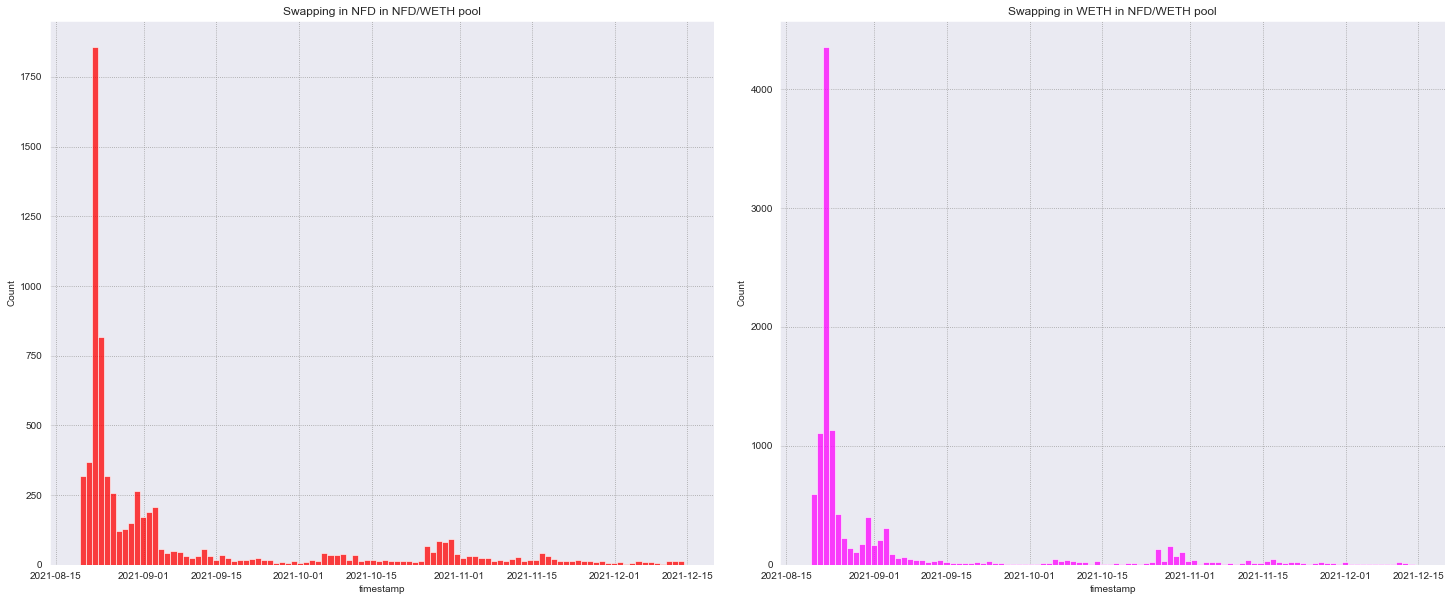

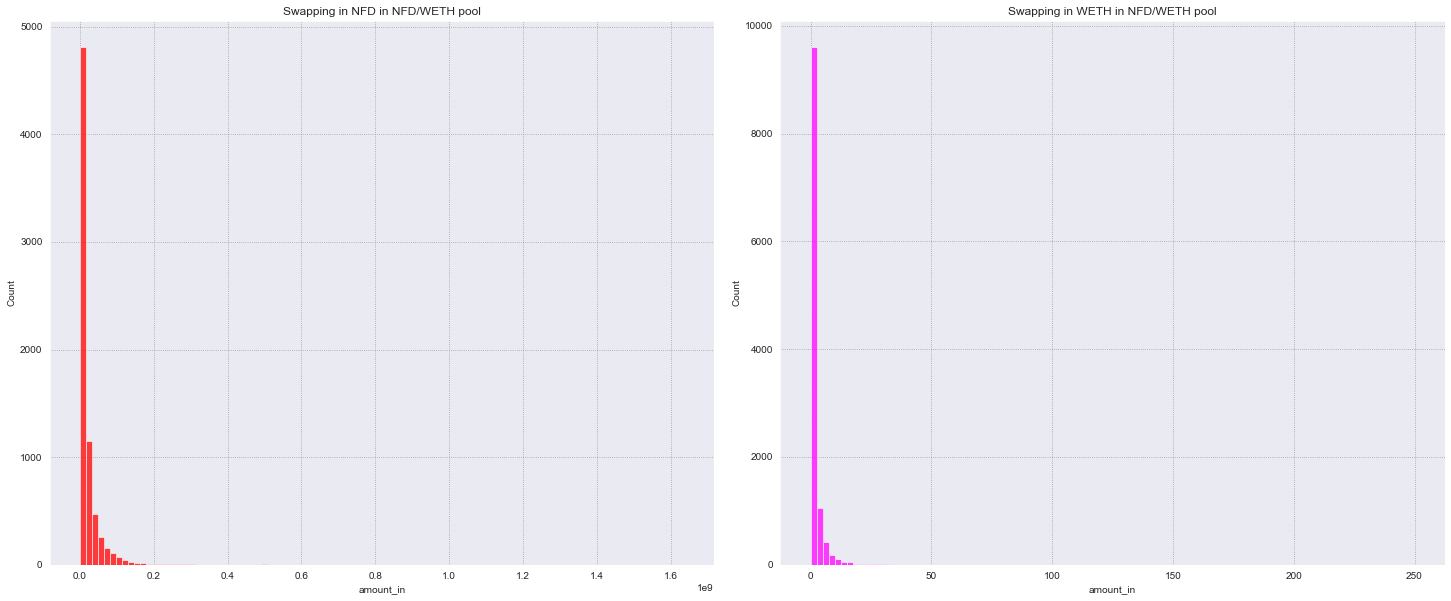

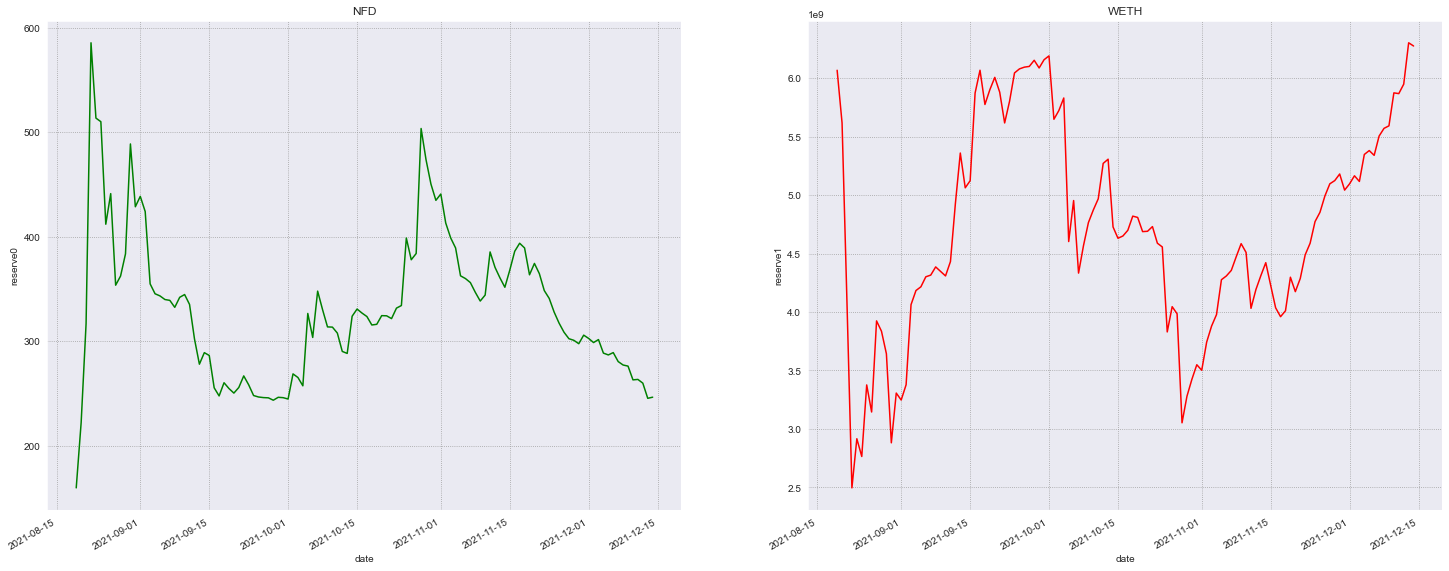

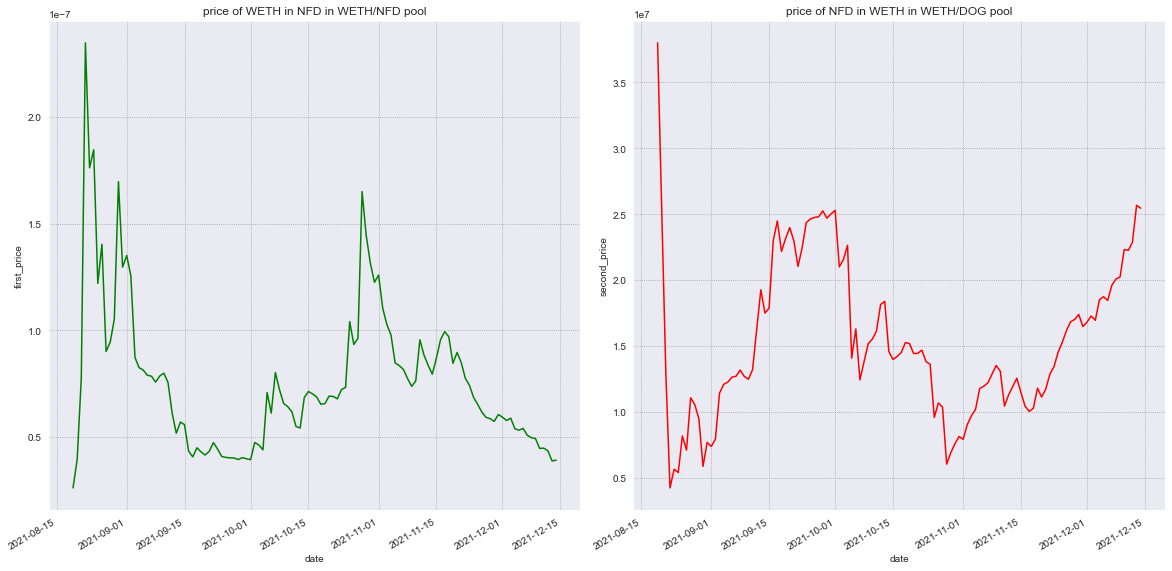

In [12]:
nfd_weth_df = get_df_with_swap_prices_and_change_rates(nfd_weth_df, 'NFD', 'WETH')

pyplot_line_swap_prices(nfd_weth_df, 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(nfd_weth_df, 'NFD', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(nfd_weth_df, 'NFD', 'WETH', 'Moving averages change rates for NFD',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=nfd_weth_df[(nfd_weth_df.token_in == 'NFD')], 
                                     pool_name="NFD/WETH for NFD")
show_swaps_amount_in_moving_averages(swaps_df=nfd_weth_df[(nfd_weth_df.token_in == 'WETH')], 
                                     pool_name="NFD/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'NFD'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in NFD in NFD/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in NFD/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'NFD'], x='amount_in', bins=100, color='red').set_title("Swapping in NFD in NFD/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=nfd_weth_df[nfd_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in NFD/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(nfd_weth_reserves_df,
                                           first_token_reserve_name="NFD", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(nfd_weth_reserves_df, 
                                        first_token_price_name="price of WETH in NFD in WETH/NFD pool", 
                                        second_token_price_name="price of NFD in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

# LADY/WETH

In [15]:
lady_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\lady_weth_swaps.pkl')
lady_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_mints.pkl")
# lady_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_burns.pkl")
lady_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\lady_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


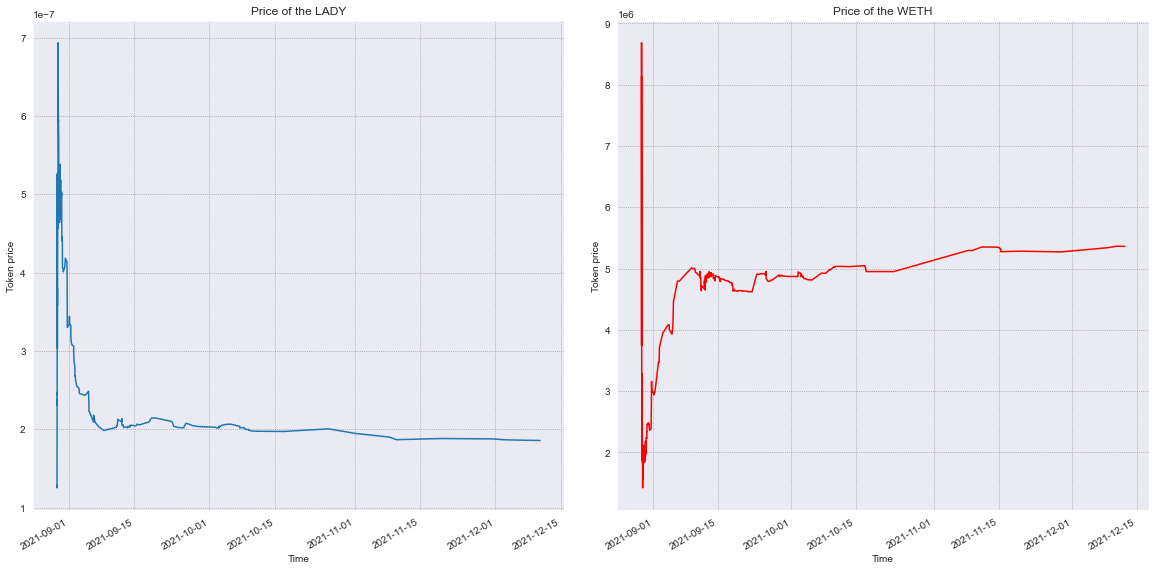

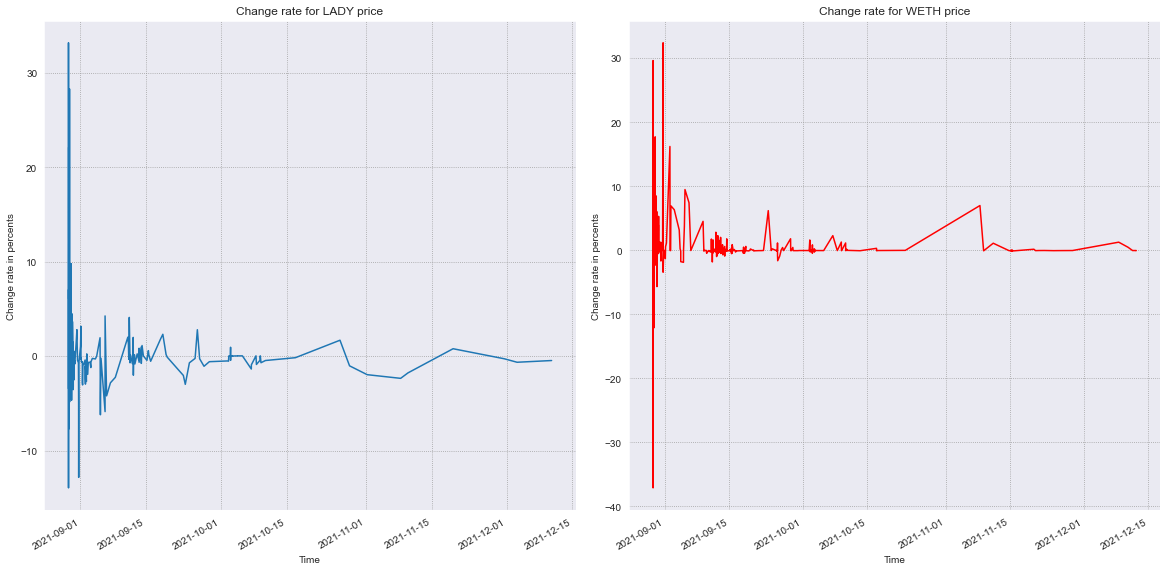

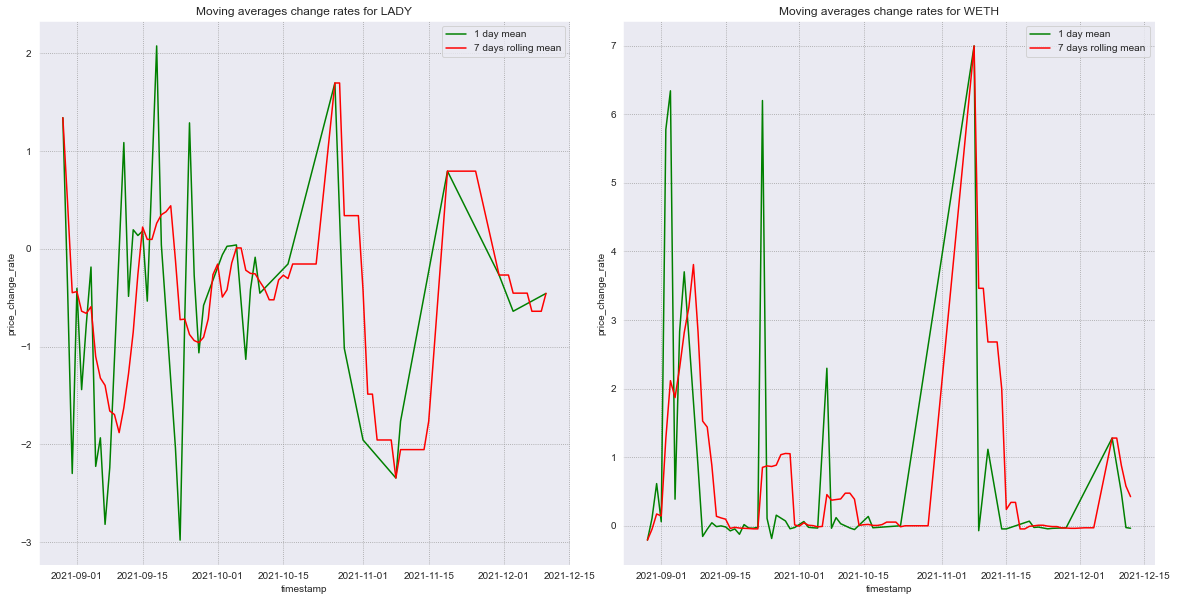

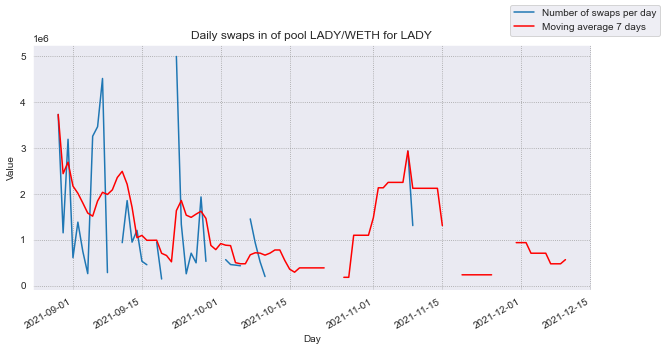

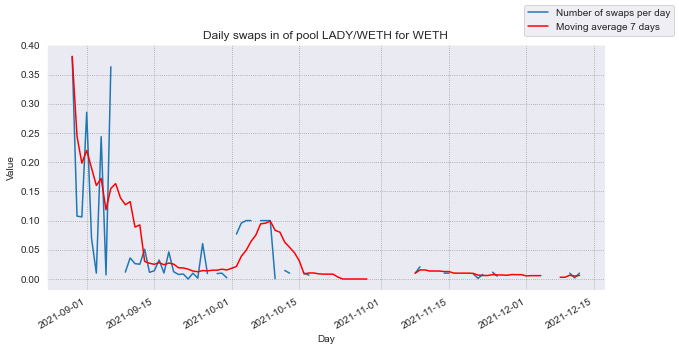

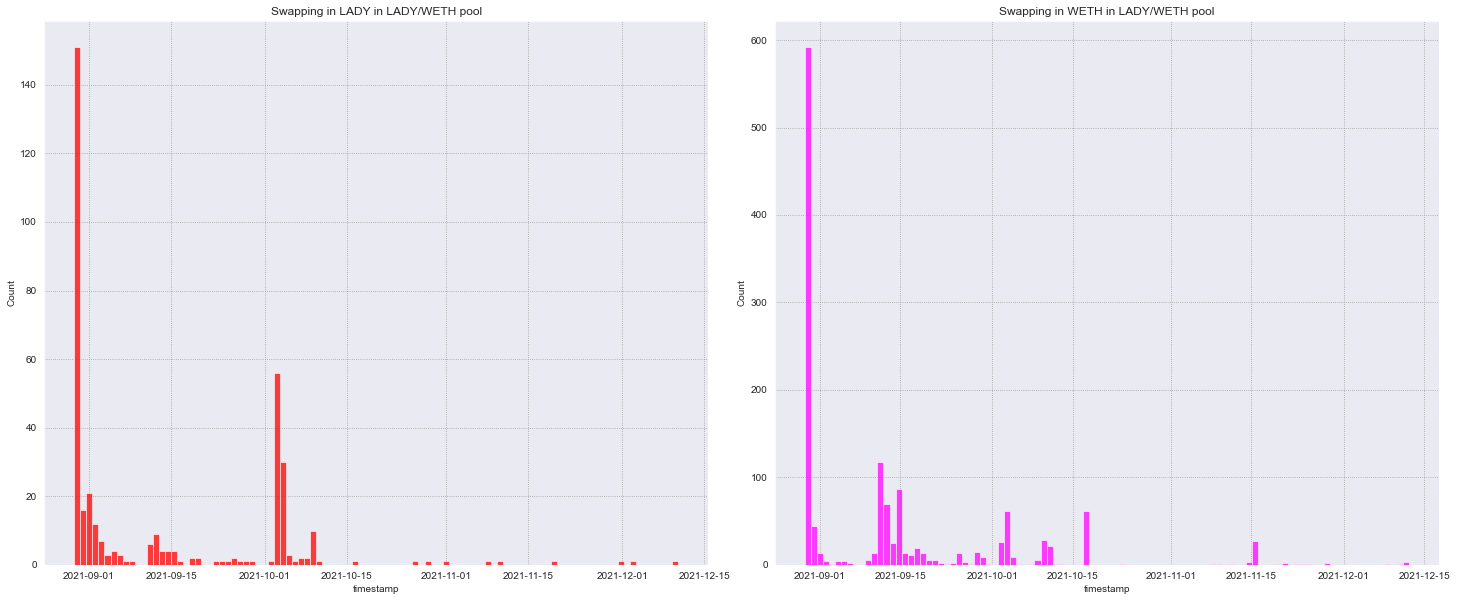

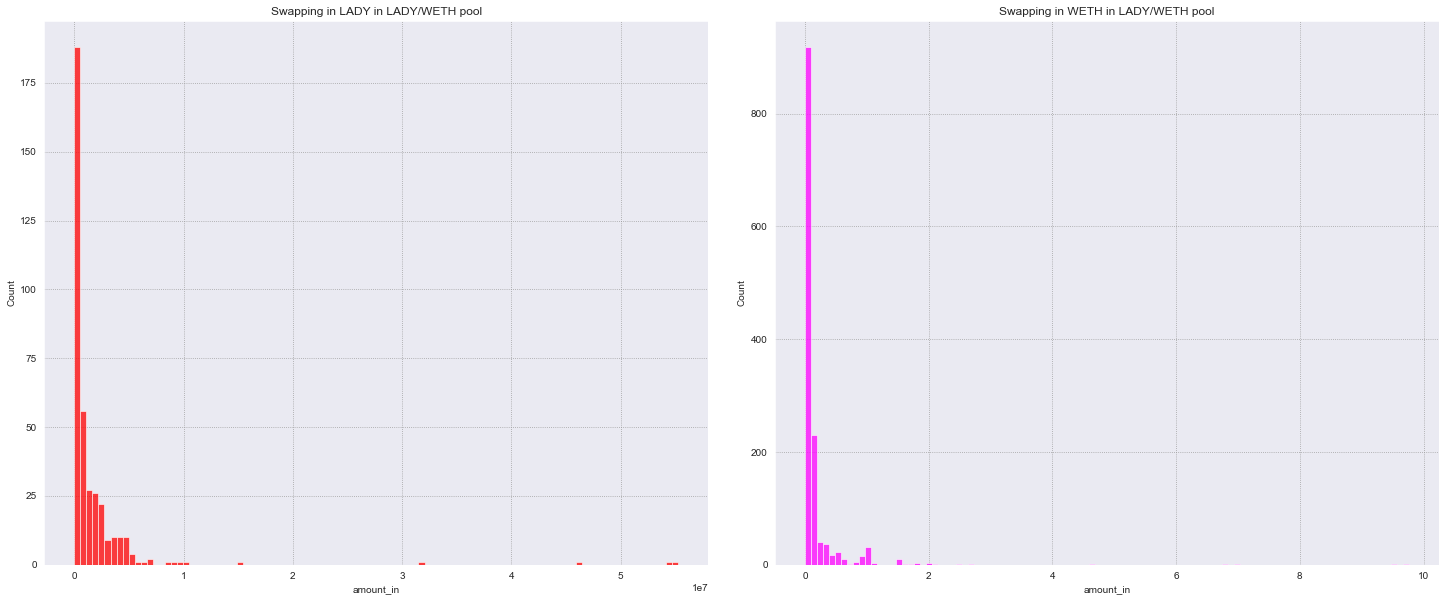

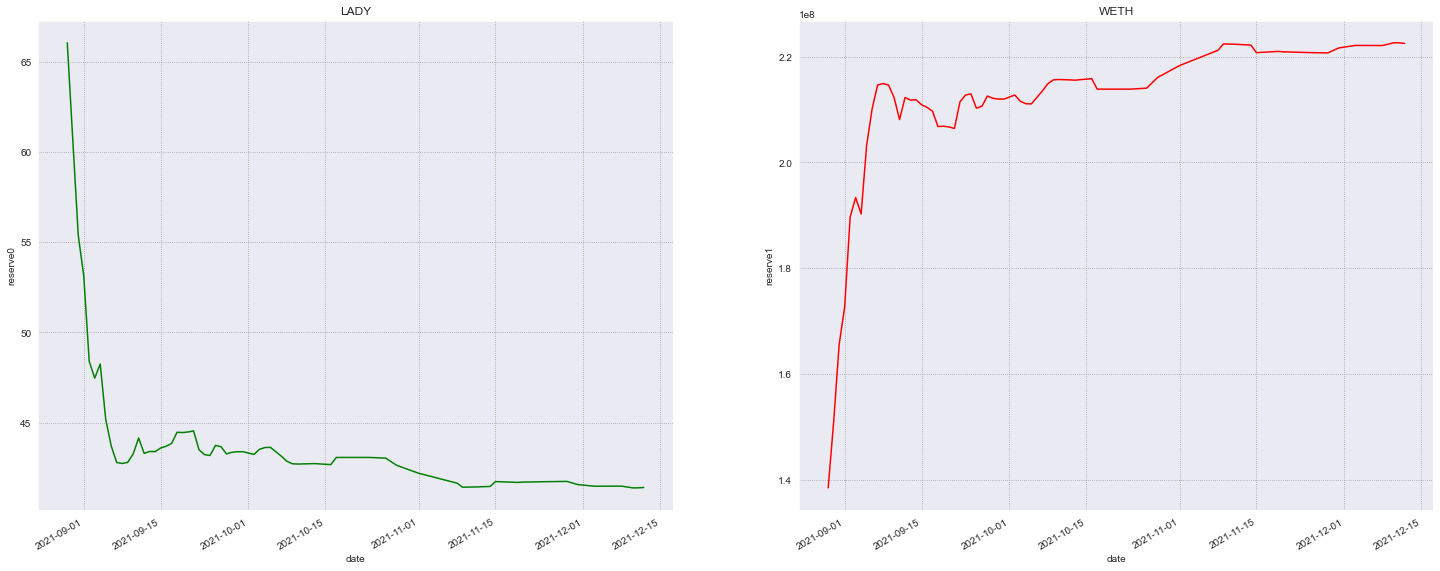

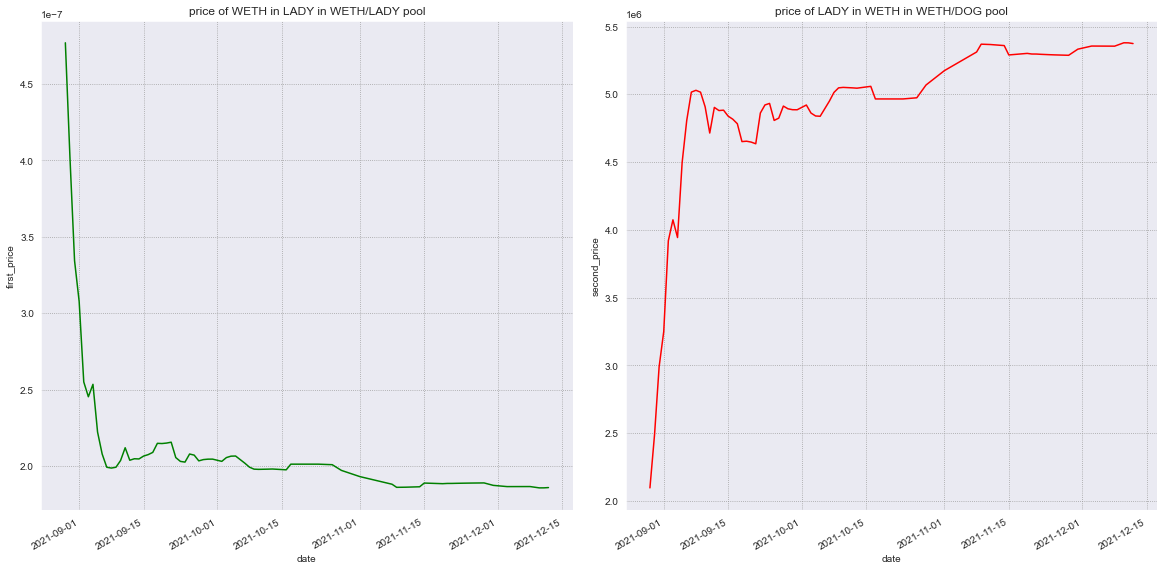

In [16]:
lady_weth_df = get_df_with_swap_prices_and_change_rates(lady_weth_df, 'LADY', 'WETH')

pyplot_line_swap_prices(lady_weth_df, 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(lady_weth_df, 'LADY', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(lady_weth_df, 'LADY', 'WETH', 'Moving averages change rates for LADY',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=lady_weth_df[(lady_weth_df.token_in == 'LADY')], 
                                     pool_name="LADY/WETH for LADY")
show_swaps_amount_in_moving_averages(swaps_df=lady_weth_df[(lady_weth_df.token_in == 'WETH')], 
                                     pool_name="LADY/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'LADY'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in LADY in LADY/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in LADY/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'LADY'], x='amount_in', bins=100, color='red').set_title("Swapping in LADY in LADY/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=lady_weth_df[lady_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in LADY/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(lady_weth_reserves_df,
                                           first_token_reserve_name="LADY", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(lady_weth_reserves_df, 
                                        first_token_price_name="price of WETH in LADY in WETH/LADY pool", 
                                        second_token_price_name="price of LADY in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

# CAT/WETH

In [18]:
cat_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\cat_weth_swaps.pkl')
cat_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_mints.pkl")
# cat_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_burns.pkl")
cat_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\cat_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


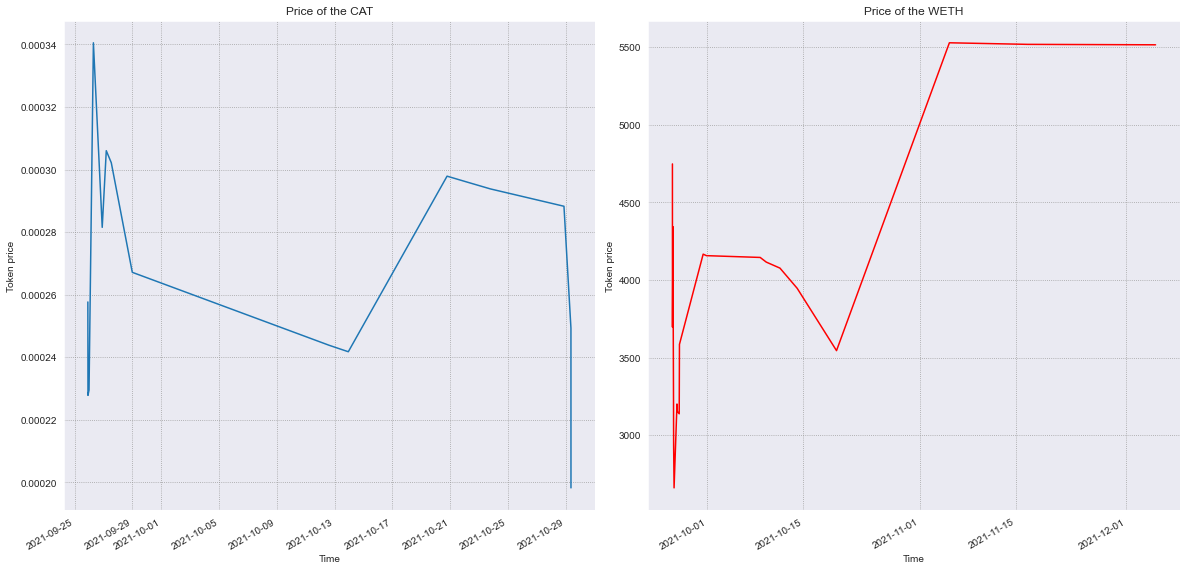

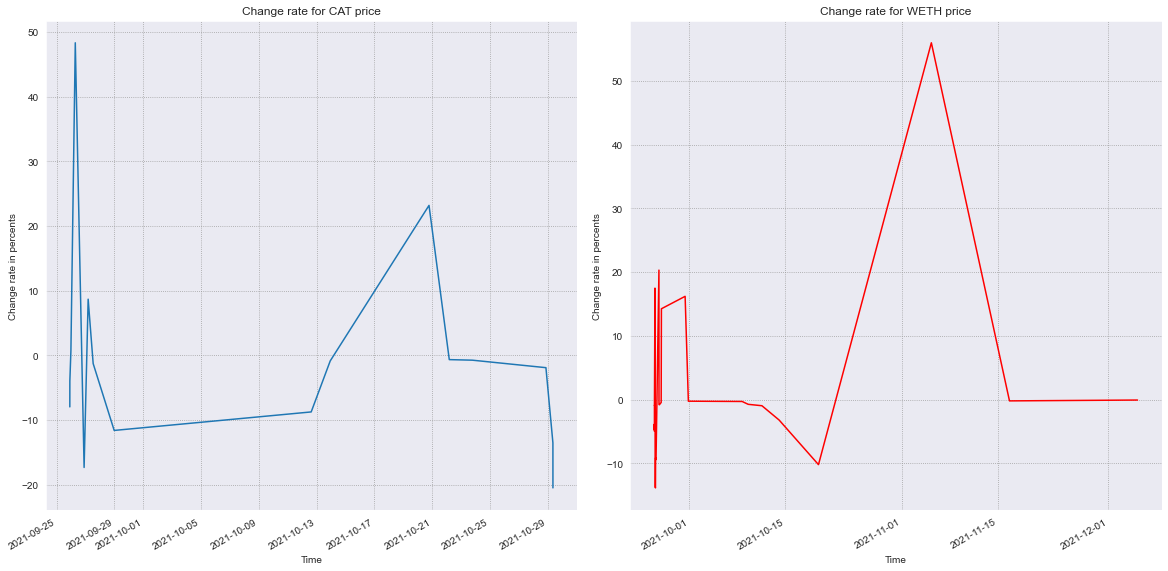

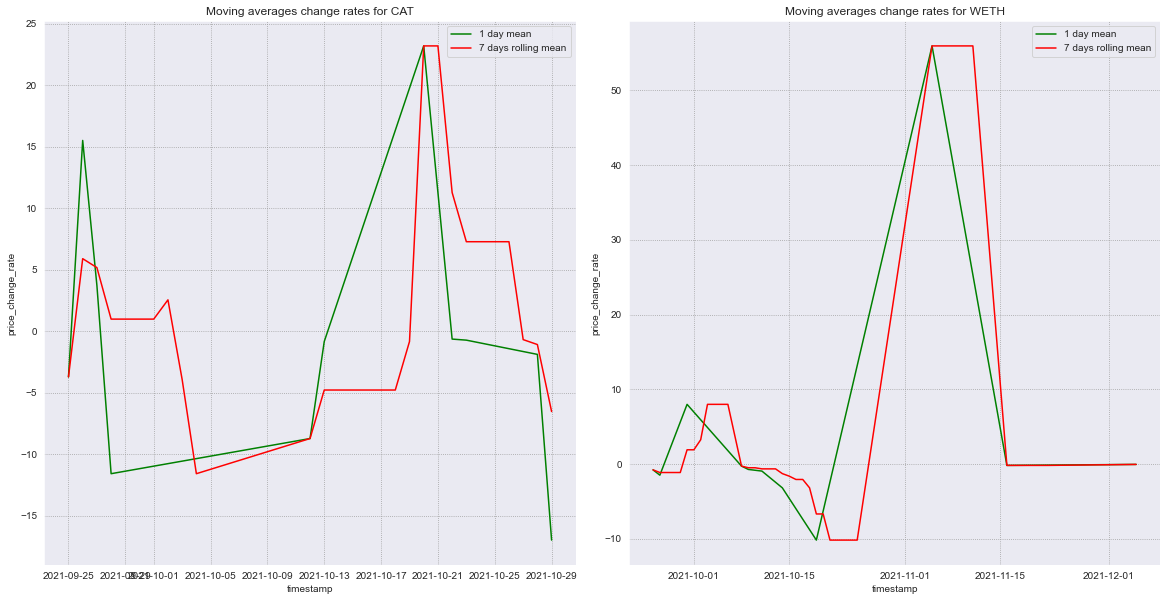

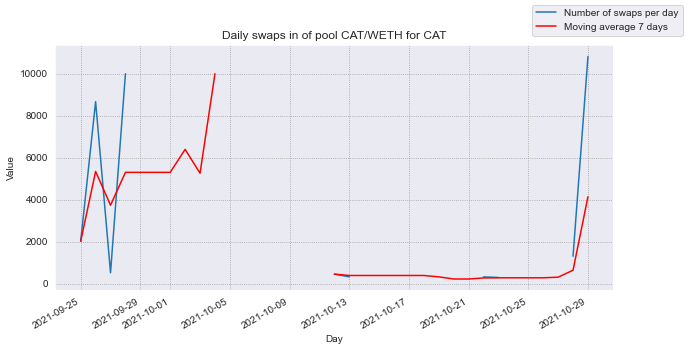

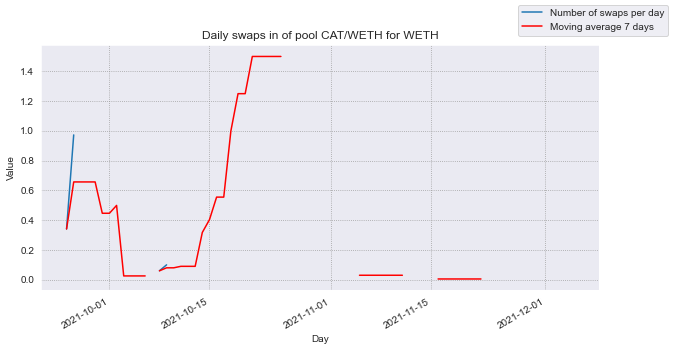

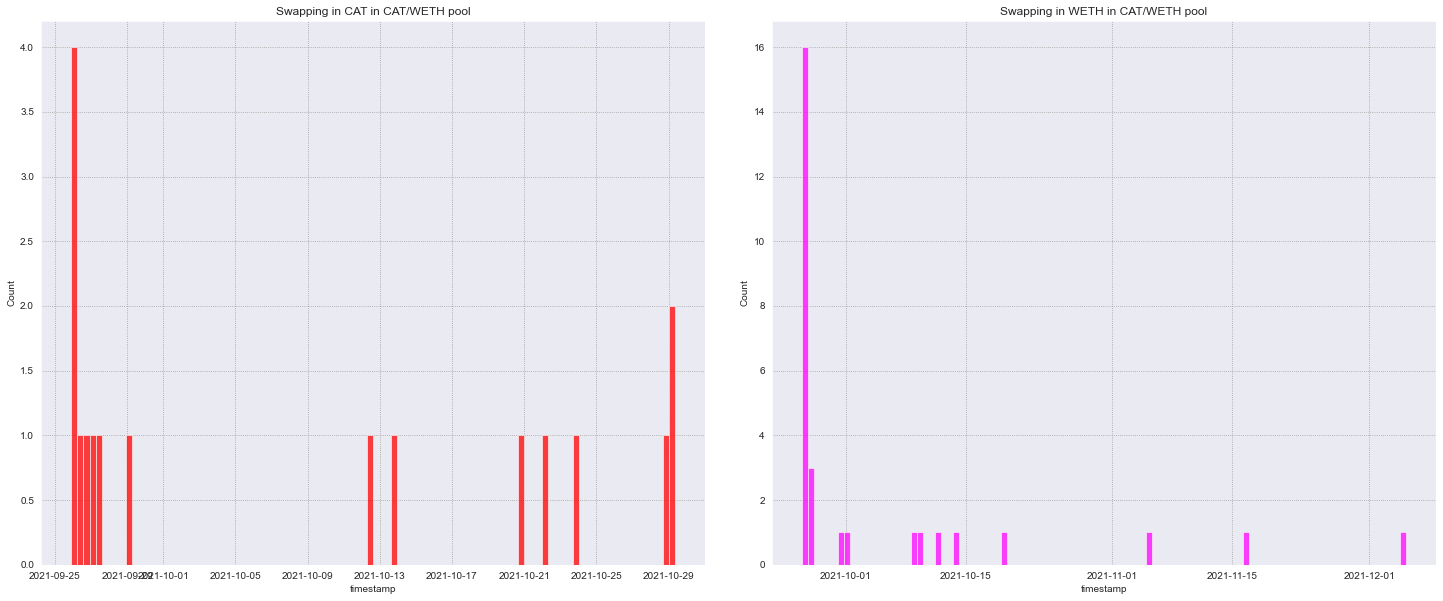

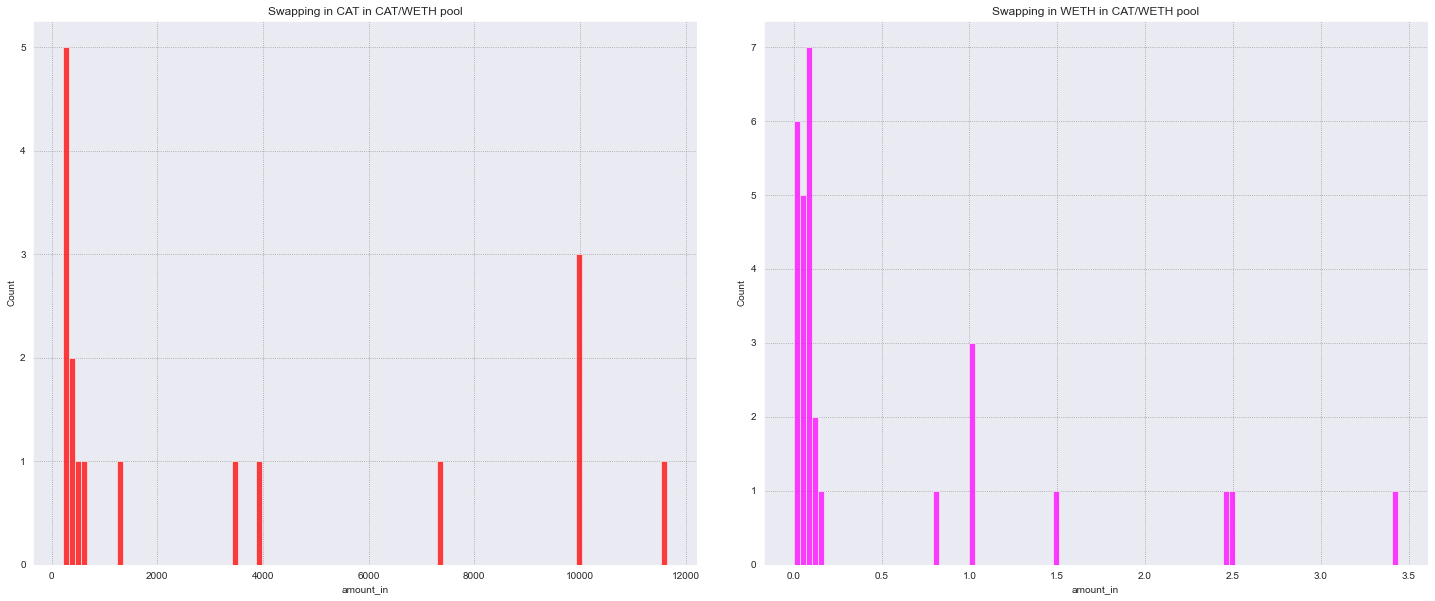

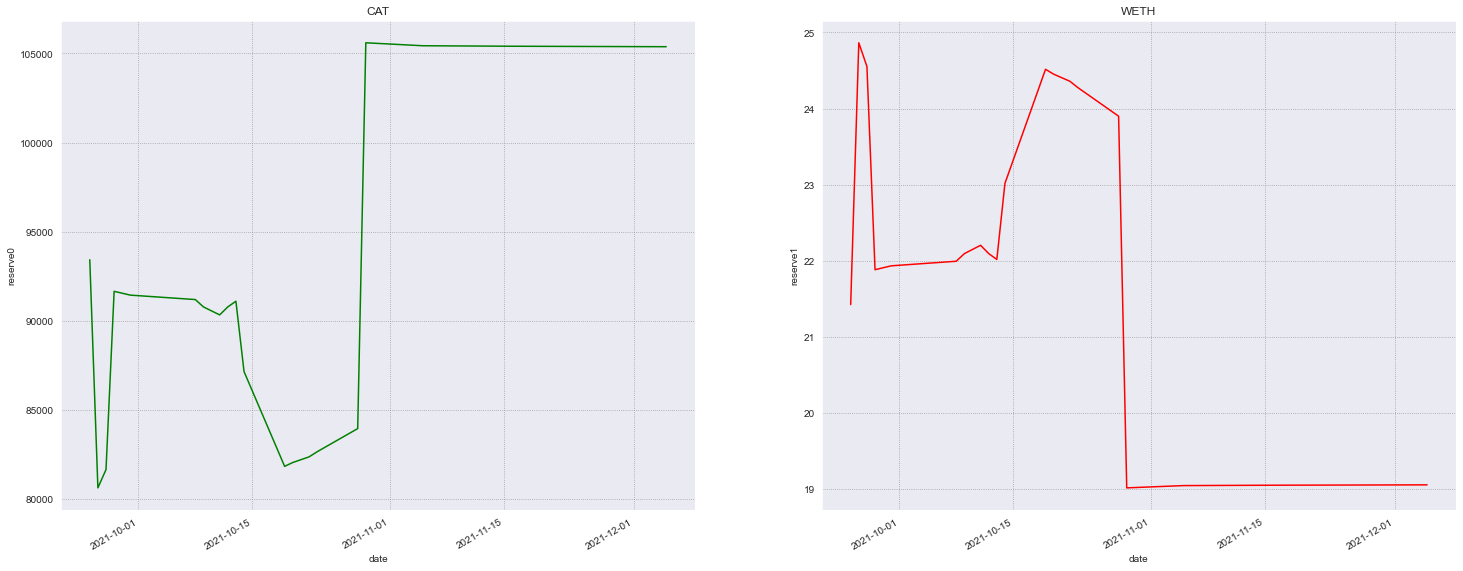

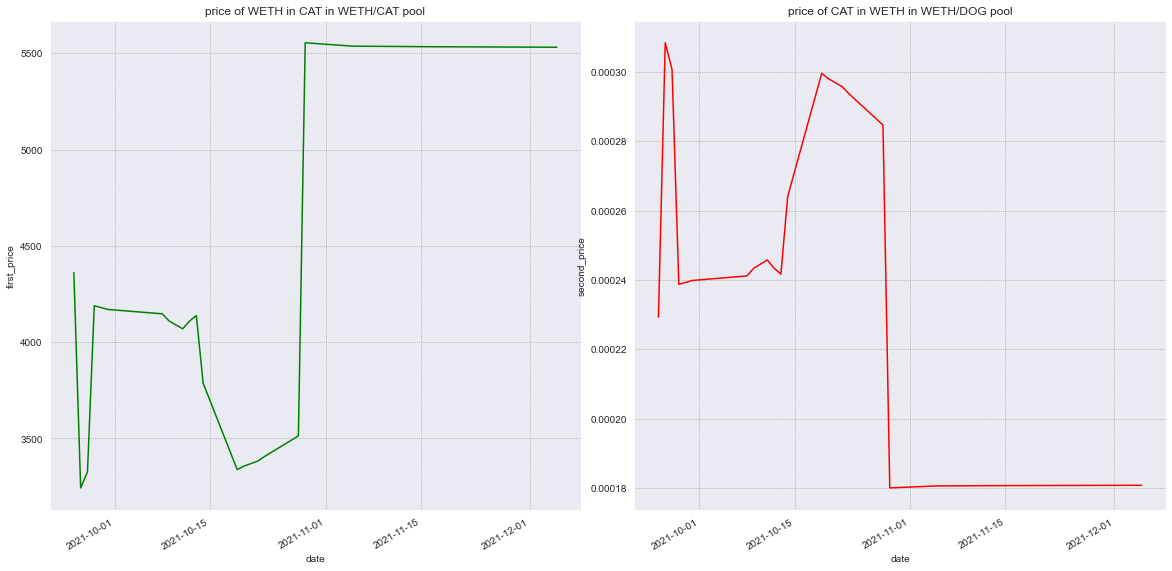

In [19]:
cat_weth_df = get_df_with_swap_prices_and_change_rates(cat_weth_df, 'CAT', 'WETH')

pyplot_line_swap_prices(cat_weth_df, 'CAT', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(cat_weth_df, 'CAT', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(cat_weth_df, 'CAT', 'WETH', 'Moving averages change rates for CAT',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=cat_weth_df[(cat_weth_df.token_in == 'CAT')], 
                                     pool_name="CAT/WETH for CAT")
show_swaps_amount_in_moving_averages(swaps_df=cat_weth_df[(cat_weth_df.token_in == 'WETH')], 
                                     pool_name="CAT/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'CAT'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in CAT in CAT/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in CAT/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'CAT'], x='amount_in', bins=100, color='red').set_title("Swapping in CAT in CAT/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=cat_weth_df[cat_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in CAT/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(cat_weth_reserves_df,
                                           first_token_reserve_name="CAT", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(cat_weth_reserves_df, 
                                        first_token_price_name="price of WETH in CAT in WETH/CAT pool", 
                                        second_token_price_name="price of CAT in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

# TIARA/WETH

In [20]:
tiara_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\tiara_weth_swaps.pkl')
tiara_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_mints.pkl")
tiara_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_burns.pkl")
tiara_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\tiara_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


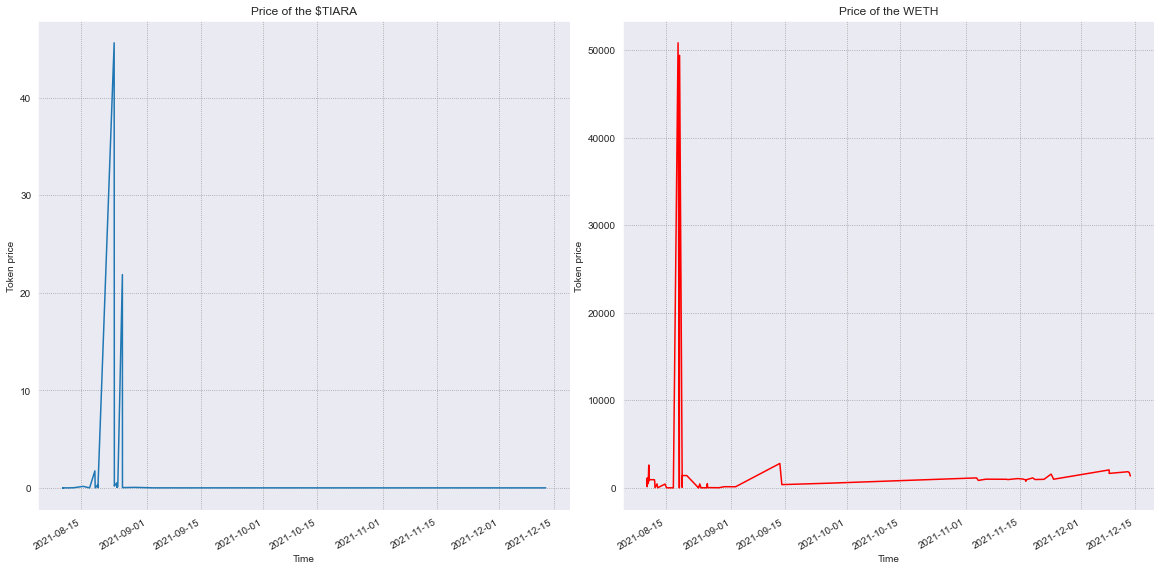

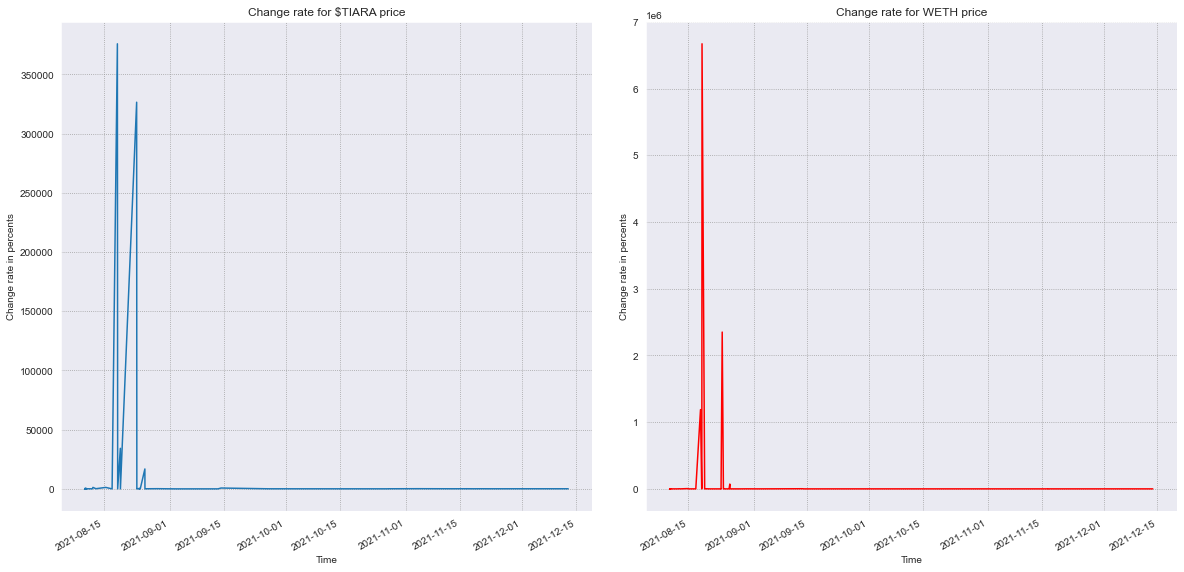

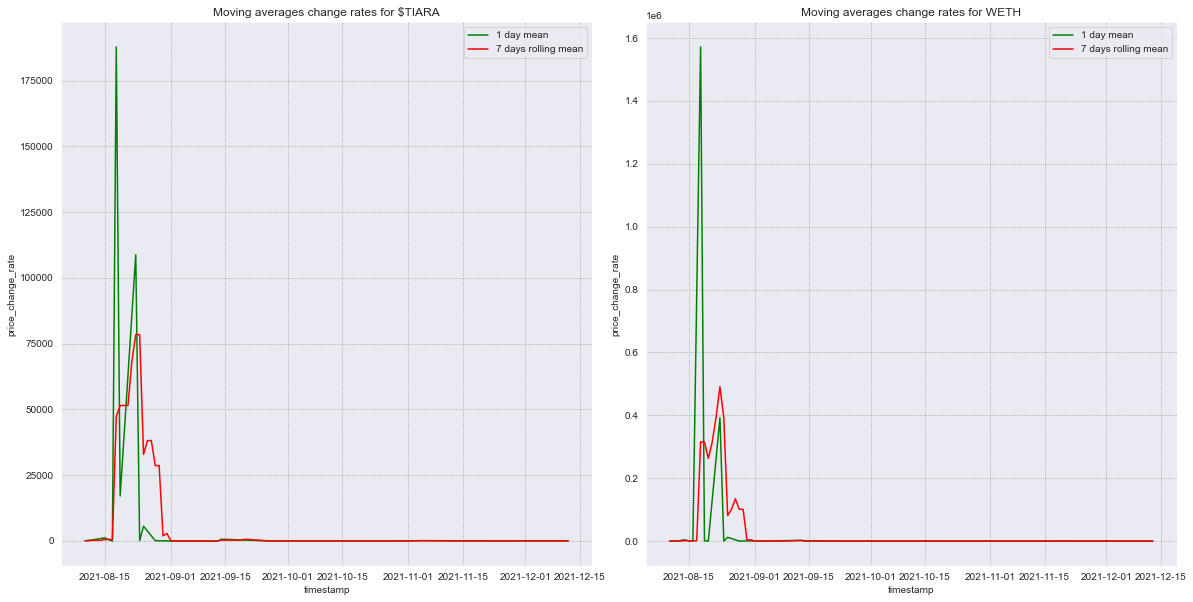

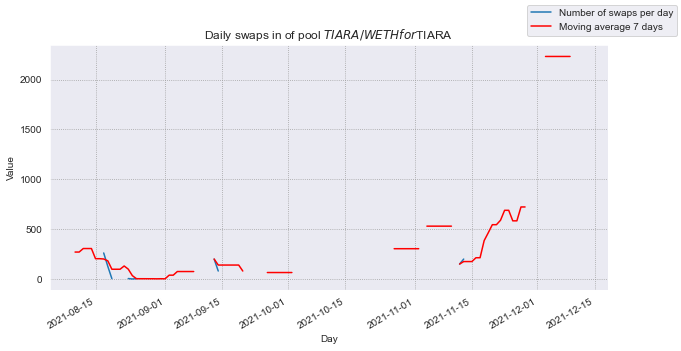

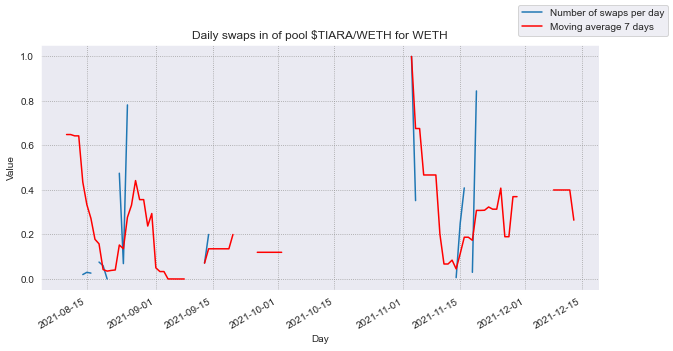

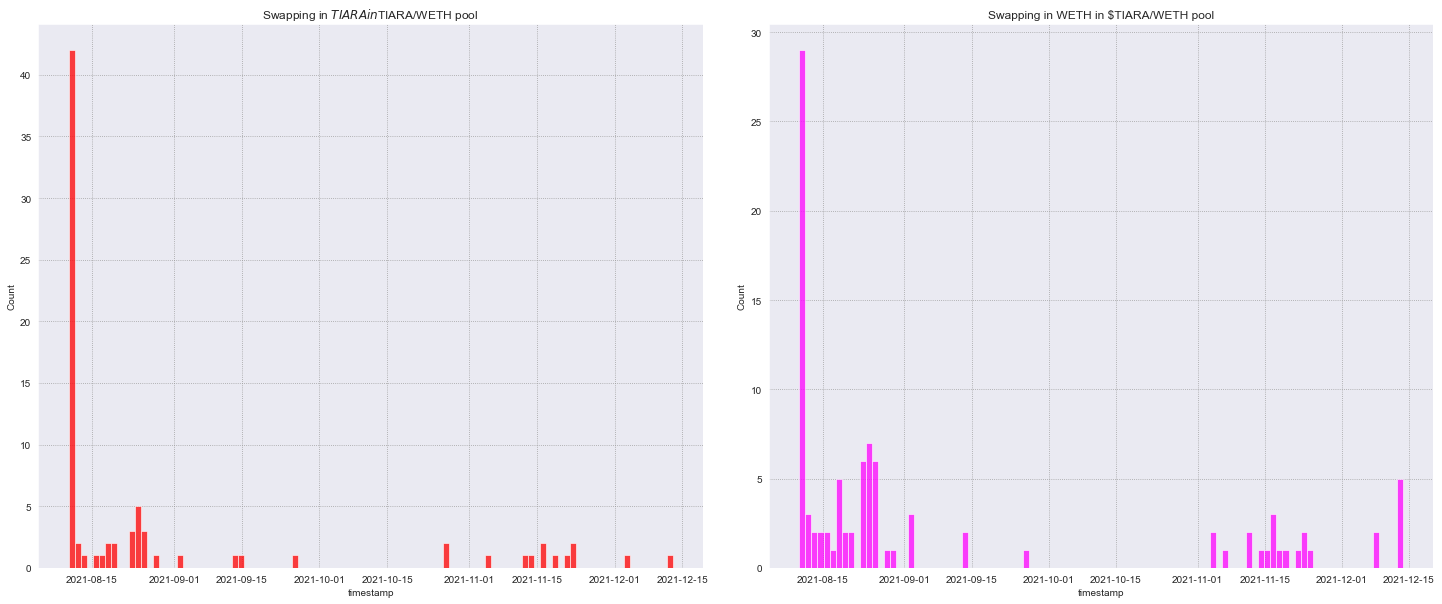

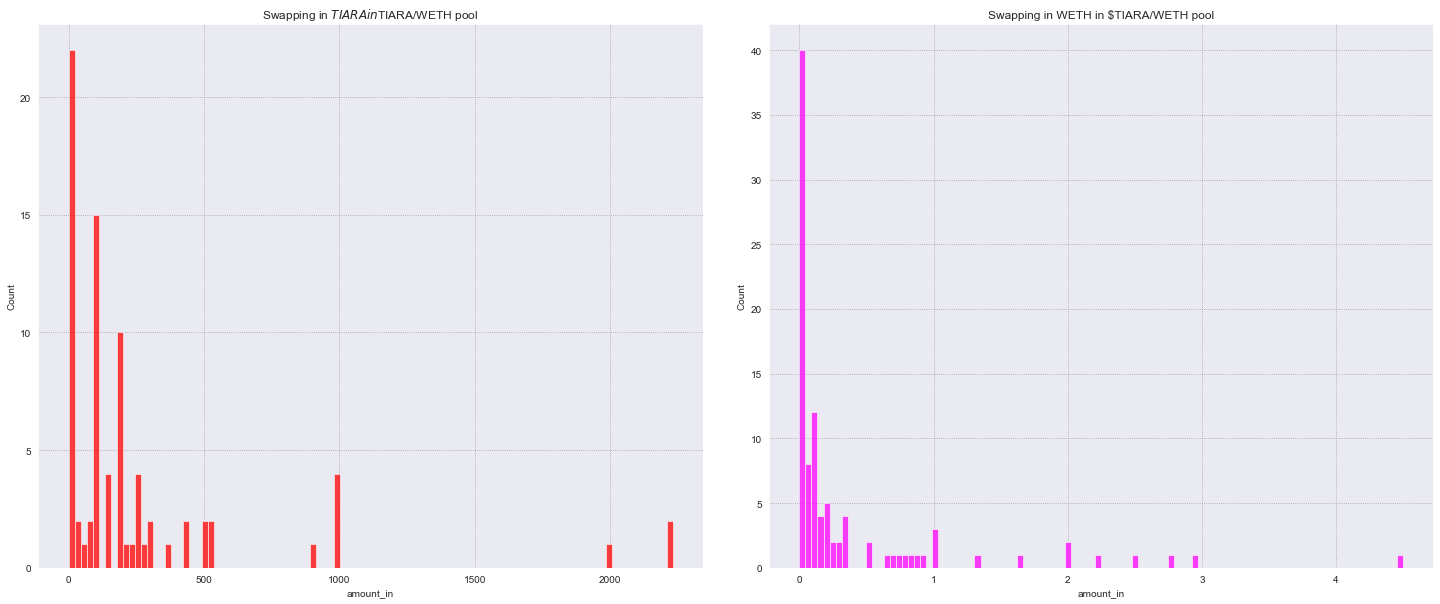

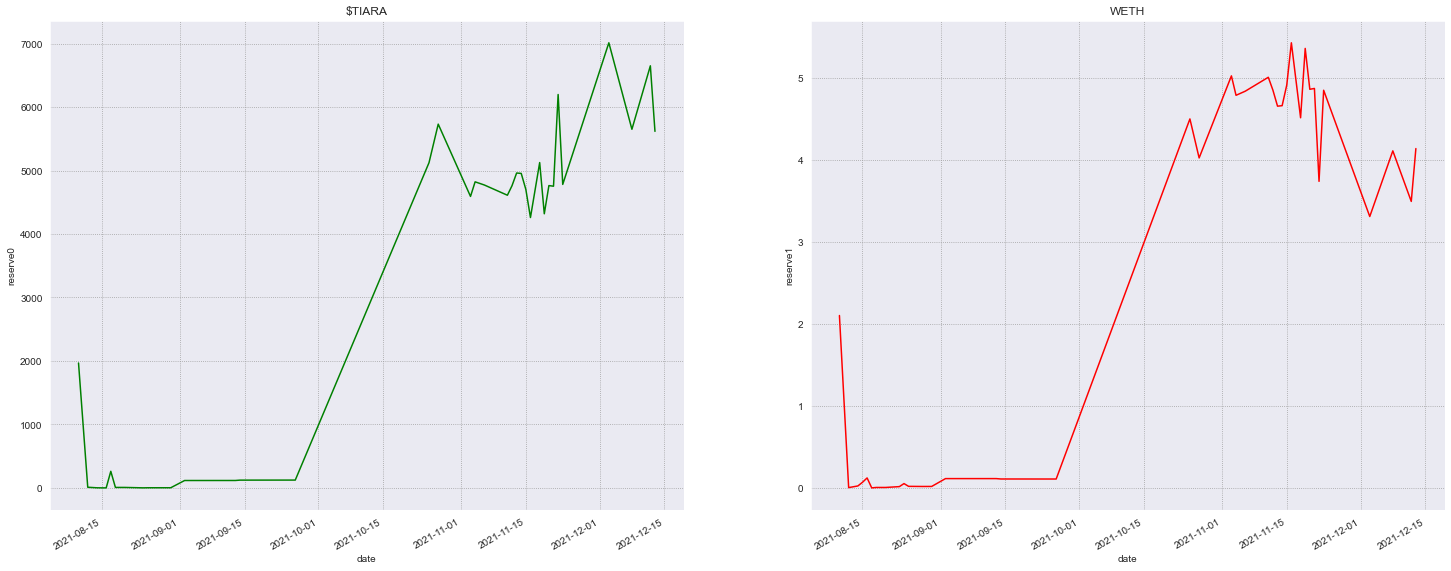

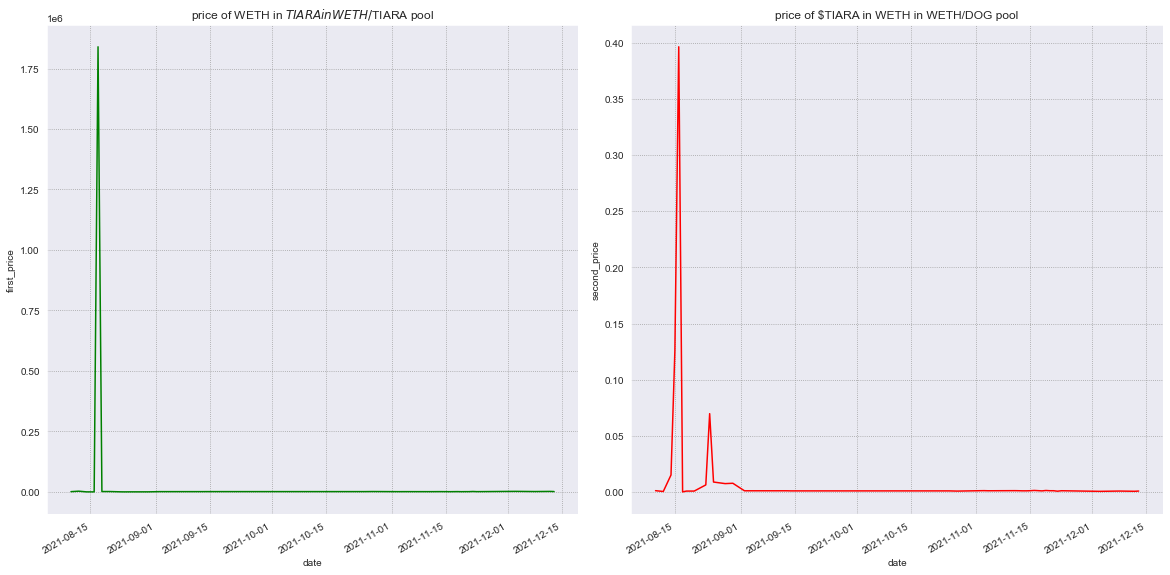

In [21]:
tiara_weth_df = get_df_with_swap_prices_and_change_rates(tiara_weth_df, '$TIARA', 'WETH')

pyplot_line_swap_prices(tiara_weth_df, '$TIARA', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(tiara_weth_df, '$TIARA', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(tiara_weth_df, '$TIARA', 'WETH', 'Moving averages change rates for $TIARA',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=tiara_weth_df[(tiara_weth_df.token_in == '$TIARA')], 
                                     pool_name="$TIARA/WETH for $TIARA")
show_swaps_amount_in_moving_averages(swaps_df=tiara_weth_df[(tiara_weth_df.token_in == 'WETH')], 
                                     pool_name="$TIARA/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == '$TIARA'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in $TIARA in $TIARA/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in $TIARA/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == '$TIARA'], x='amount_in', bins=100, color='red').set_title("Swapping in $TIARA in $TIARA/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=tiara_weth_df[tiara_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in $TIARA/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(tiara_weth_reserves_df,
                                           first_token_reserve_name="$TIARA", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(tiara_weth_reserves_df, 
                                        first_token_price_name="price of WETH in $TIARA in WETH/$TIARA pool", 
                                        second_token_price_name="price of $TIARA in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)

# ACAB/WETH

In [23]:
acab_weth_df = pd.read_pickle(os.getcwd() + '\\pkl_stories\\acab_weth_swaps.pkl')
acab_weth_mints_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_mints.pkl")
# acab_weth_burns_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_burns.pkl")
acab_weth_reserves_df = pd.read_pickle(os.getcwd() + "\\pkl_stories\\acab_weth_reserves.pkl")

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


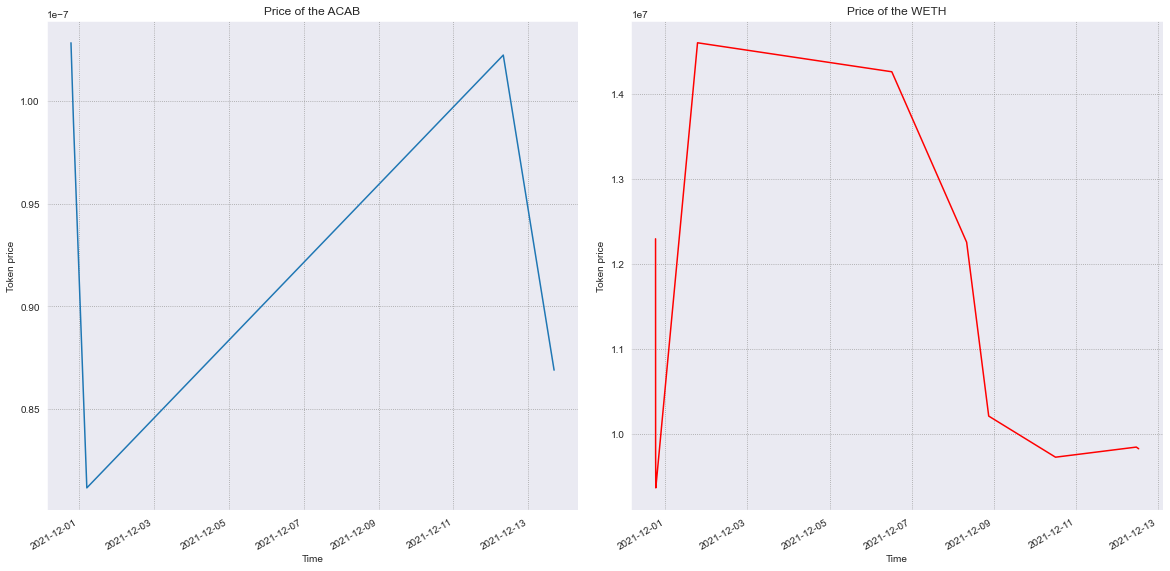

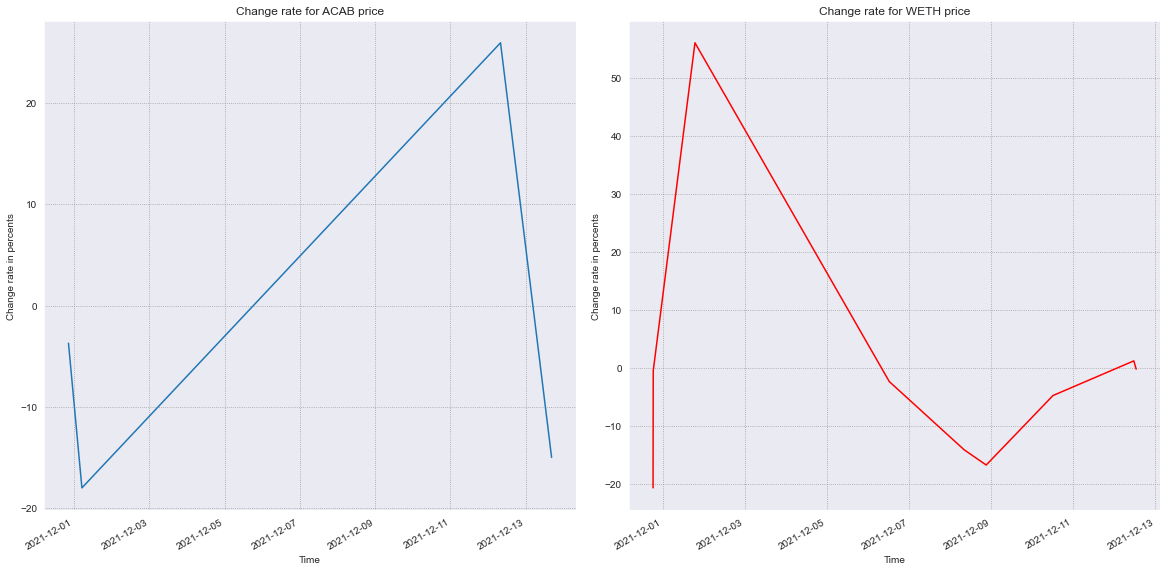

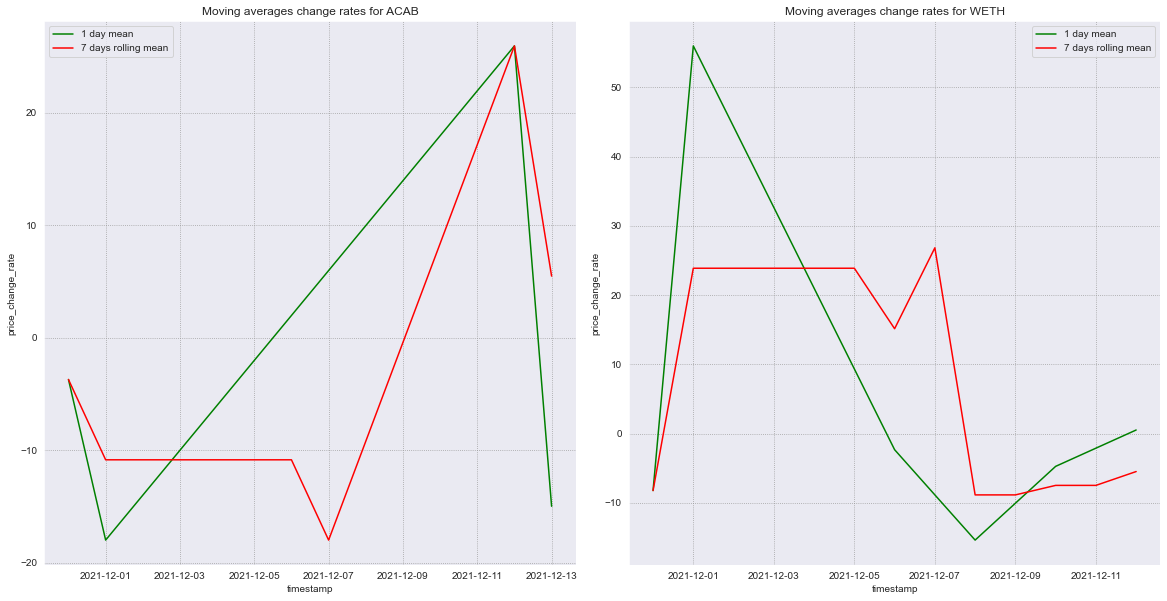

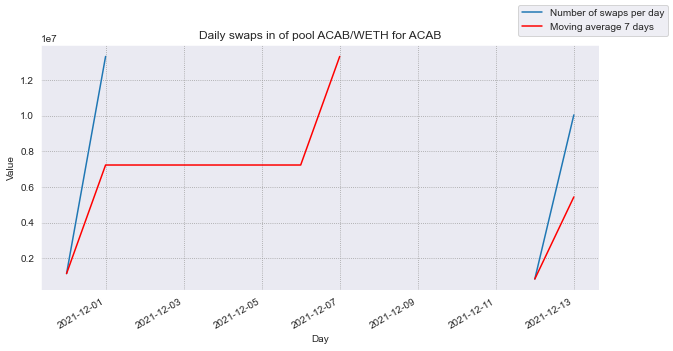

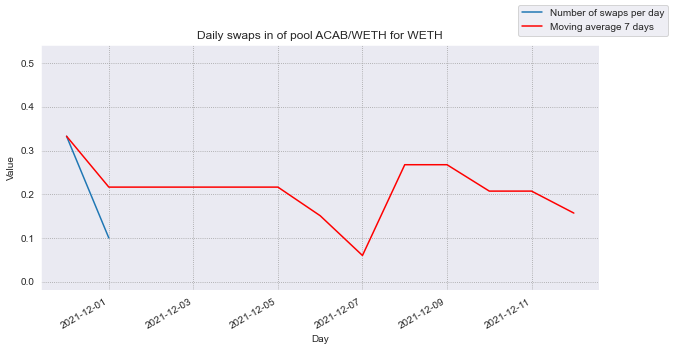

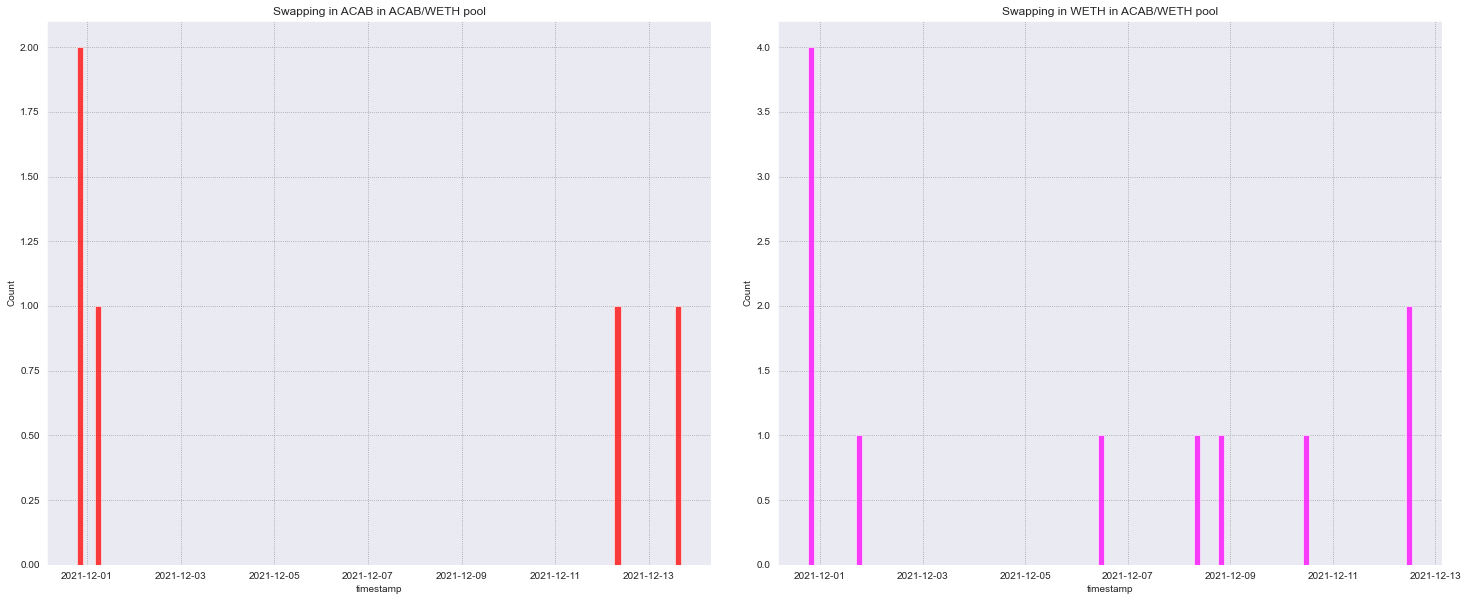

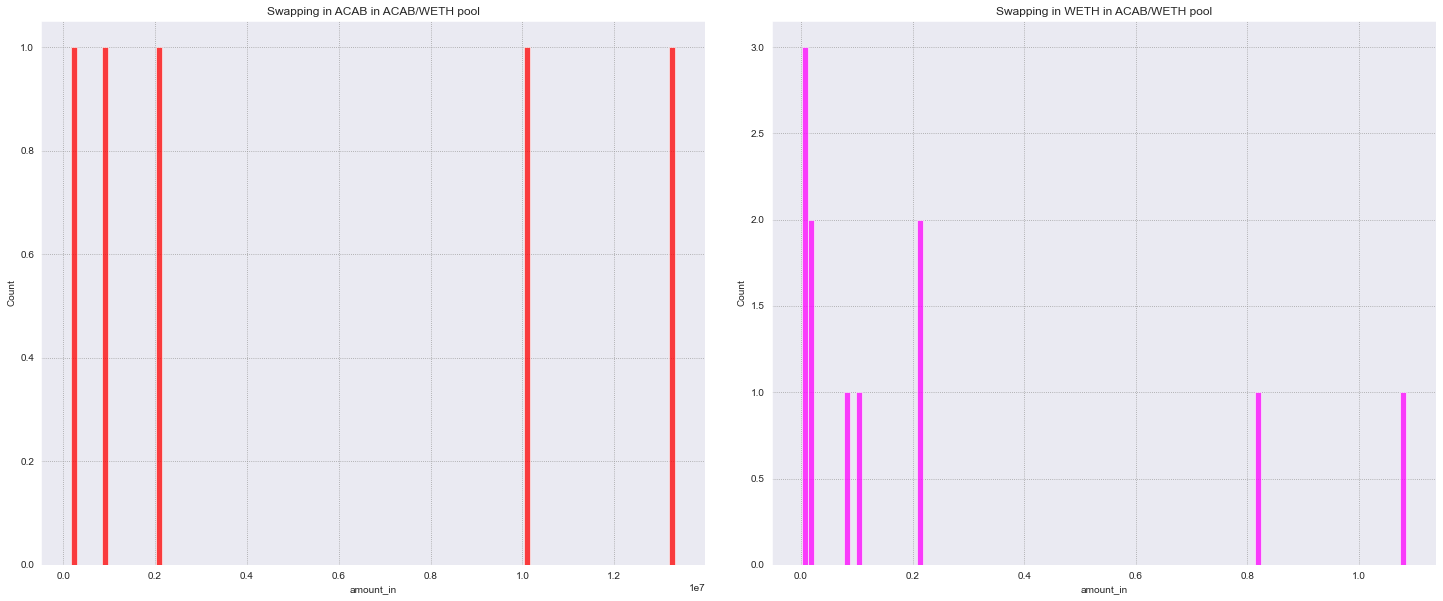

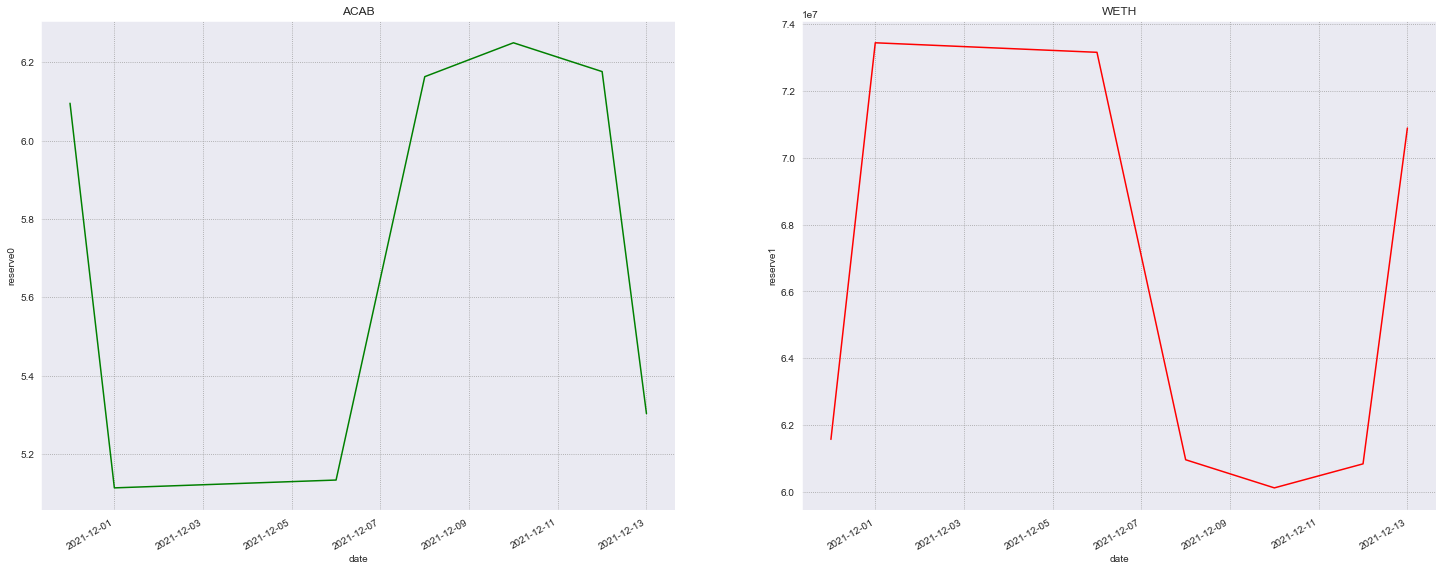

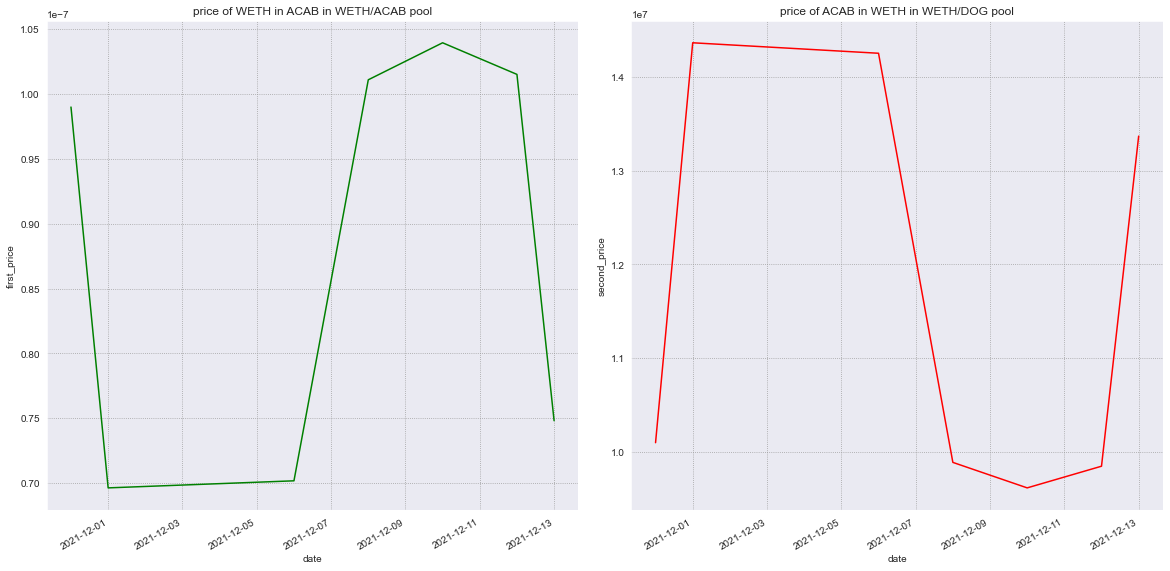

In [24]:
acab_weth_df = get_df_with_swap_prices_and_change_rates(acab_weth_df, 'ACAB', 'WETH')

pyplot_line_swap_prices(acab_weth_df, 'ACAB', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

pyplot_line_swap_change_rate(acab_weth_df, 'ACAB', 'WETH', xsize=20, ysize=10, wspace=0.1, hspace=0.1)

swaps_price_increase_rates_moving_averages(acab_weth_df, 'ACAB', 'WETH', 'Moving averages change rates for ACAB',
                                           'Moving averages change rates for WETH', x_size=20, y_size=10, wspace=0.1, hspace=0.1)

show_swaps_amount_in_moving_averages(swaps_df=acab_weth_df[(acab_weth_df.token_in == 'ACAB')], 
                                     pool_name="ACAB/WETH for ACAB")
show_swaps_amount_in_moving_averages(swaps_df=acab_weth_df[(acab_weth_df.token_in == 'WETH')], 
                                     pool_name="ACAB/WETH for WETH")

# swapping values histograms
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'ACAB'], x='timestamp', 
             bins=100, color='red').set_title("Swapping in ACAB in ACAB/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'WETH'], x='timestamp', 
             bins=100, color='magenta').set_title("Swapping in WETH in ACAB/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

# swapping in values distribution
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'ACAB'], x='amount_in', bins=100, color='red').set_title("Swapping in ACAB in ACAB/WETH pool")
plt.subplot(1, 2, 2)
sns.histplot(data=acab_weth_df[acab_weth_df.token_in == 'WETH'], x='amount_in', bins=100, color='magenta').set_title("Swapping in WETH in ACAB/WETH pool")
plt.subplots_adjust(wspace=0.1)
plt.show()

show_swaps_reserves_evolution_through_time(acab_weth_reserves_df,
                                           first_token_reserve_name="ACAB", 
                                           second_token_reserve_name="WETH", x=25, y=10)

show_pool_price_evolution_from_reserves(acab_weth_reserves_df, 
                                        first_token_price_name="price of WETH in ACAB in WETH/ACAB pool", 
                                        second_token_price_name="price of ACAB in WETH in WETH/DOG pool", 
                                        x=20, y=10, wspace=0.1)